In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Datasets

**Validation dataset:**
* Used for hyperparameter tunning
* When you train a model on the training set, it can memorize noise instead of learning general patterns.  
* Monitoring performance on a validation set tells you when your model is starting to overfit.
* Use 10–20% of your data for validation when you have thousands of samples.
* For small datasets, apply k-fold cross-validation to rotate through multiple validation and training splits.
* Ensure your validation set reflects the same distribution as your training and test sets.  

**Large datasets (10 000 <):**
* 80% training
* 10% validation
* 10% test

**Small datasets (1000 >):**
* 80% training/validation (k-fold splits)
* 20% test

## AI job

In [2]:
ai_job = pd.read_csv('/kaggle/input/global-ai-job-market-trend-2025/ai_job_dataset.csv')

salary = {}
for position in ai_job.job_title.unique():
    pos = ai_job.query('job_title == @position and salary_currency == "USD"')
    salary[position] = int(pos.salary_usd.mean())

salary = dict(sorted(salary.items(), key=lambda item: item[1], reverse=True))
salary

{'AI Specialist': 118618,
 'Head of AI': 117012,
 'AI Research Scientist': 116257,
 'ML Ops Engineer': 115754,
 'AI Architect': 115662,
 'Machine Learning Engineer': 114346,
 'Deep Learning Engineer': 113821,
 'Robotics Engineer': 113736,
 'Research Scientist': 113579,
 'AI Product Manager': 113509,
 'Data Engineer': 113436,
 'Principal Data Scientist': 113329,
 'Data Scientist': 113323,
 'AI Software Engineer': 113028,
 'Computer Vision Engineer': 112634,
 'AI Consultant': 112497,
 'Data Analyst': 110374,
 'NLP Engineer': 110361,
 'Machine Learning Researcher': 109405,
 'Autonomous Systems Engineer': 108889}

In [3]:
ai_job_future = pd.read_csv('/kaggle/input/ai-impact-on-job-market-20242030/ai_job_trends_dataset.csv')
ai_job_future['opening_difference'] = ai_job_future['Projected Openings (2030)'] - ai_job_future['Job Openings (2024)']
ai_job_future_it = ai_job_future.query('Industry == "IT"')
ai_job_future_it[['Job Title', 'opening_difference', 'Job Status', 'Automation Risk (%)', 'AI Impact Level', 'Industry']].sort_values(by='opening_difference', ascending=True)

,Job Title,opening_difference,Job Status,Automation Risk (%),AI Impact Level,Industry
10775,Quality manager,-9693,Increasing,88.95,Low,IT
22995,"Pilot, airline",-9622,Increasing,36.89,Moderate,IT
13779,Clinical psychologist,-9511,Decreasing,73.72,Moderate,IT
17016,"Research officer, government",-9432,Increasing,40.03,Low,IT
25211,"Lecturer, higher education",-9420,Increasing,86.15,Low,IT
...,...,...,...,...,...,...
21447,"Editor, commissioning",9492,Increasing,62.90,Low,IT
21048,"Designer, industrial/product",9510,Decreasing,29.82,High,IT
3673,Midwife,9562,Decreasing,50.45,Moderate,IT
18242,Corporate investment banker,9744,Increasing,4.93,Moderate,IT


## Pubg data

In [2]:
# load data
train_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
test_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')

X = train_data.drop('winPlacePerc', axis=1)
Y = train_data['winPlacePerc']

In [ ]:
with pd.option_context('display.max_columns', None):
    display(train_data)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


# EDA

| **Step**                      | **What to Do**                                                                                                                           | **Why It Matters**                                     | **Tip / Tools**                                                            |
| ----------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------ | -------------------------------------------------------------------------- |
| **1. Initial Inspection**     | • Check shape, dtypes, head/tail<br>• Summary stats (mean, median, std, unique counts)                                                   | Understand data structure and spot anomalies early     | `df.info()`, `df.head()`, `df.describe()`                                  |
| **2. Data Quality Check**     | • Detect duplicates<br>• Identify missing values and encoding issues<br>• Find inconsistencies                                           | Avoid skewed analysis due to poor data                 | `df.duplicated()`, `df.isnull()`, `missingno`                              |
| **3. Univariate Exploration** | • Plot histograms/density for numeric<br>• Box plots for outliers<br>• Bar charts for categories                                         | Reveal distributions, skewness, and anomalies          | `sns.histplot()`, `sns.boxplot()`, `df.value_counts()`                     |
| **4. Bivariate Analysis**     | • Scatter/pair plots for numeric<br>• Heatmap of correlations<br>• Countplots for category combos                                        | Uncover relationships and multicollinearity            | `sns.scatterplot()`, `sns.heatmap()`, `sns.countplot()`                    |
| **5. Missing & Outliers**     | • Heatmap/matrix for missingness<br>• Box/violin plots for continuous outliers                                                           | Guides decisions on cleaning and transformations       | `missingno.matrix()`, `sns.violinplot()`                                   |
| **6. Data Cleaning**          | • Impute or drop missing values<br>• Remove duplicates<br>• Standardize formats & resolve inconsistencies<br>• Detect and treat outliers | Prepares data for reliable modeling                    | `SimpleImputer`, `df.drop_duplicates()`, `df.fillna()`, `z‑score` or `IQR` |
| **7. Transform & Encode**     | • Scale numeric (standard/min–max)<br>• Encode categoricals (one-hot, label, ordinal)<br>• Convert types (date, category)                | Ensures features are compatible with model assumptions | `StandardScaler`, `MinMaxScaler`, `pd.get_dummies()`                       |
| **8. Feature Engineering**    | • Create features (ratios, datetime parts)<br>• Drop redundant features (via correlation/domain knowledge)                               | Boosts model performance and reduces noise             | `df.corr()`, predicate logic, domain expertise                             |
| **9. Document & Iterate**     | • Log all transformations & decisions<br>• Revisit steps based on new findings                                                           | Promotes reproducibility and ensures thoroughness      | Code comments, data notebooks, changelogs                                  |


**Your Final Outcome:**

By the end of **EDA**, you should have:

* A comprehensive understanding of your data's quality, structure, and characteristics. 
* Clear documentation of data issues and their potential impacts. 
* A preprocessing strategy based on your findings. 
* Initial hypotheses about which features might be most important. 
* A sense of what modeling approaches might work best given your data's properties.

*The key insight is that EDA isn't just about checking boxes - it's about building intuition that will guide every subsequent decision in your machine learning pipeline. The distribution analysis is just the foundation for this deeper understanding.*

## Initial inspection

In [13]:
train_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
display(train_data.info())
display(train_data.describe())

## Checking data quality

In [ ]:
# Duplicates
train_data.duplicated('Id').value_counts()

In [ ]:
# Nans
display(train_data.isna().sum())

## Univariant exploration

**Why Check Data Distribution?**

* Understanding the nature of your data: Is it normally distributed, skewed, bimodal? This tells you about the underlying processes that generated your data and helps you choose appropriate modeling techniques.

* Identifying potential issues: Extreme skewness, unexpected peaks, or gaps in the distribution can signal data quality problems, measurement errors, or important business insights.

* Informing preprocessing decisions: The distribution shape directly impacts what transformations or scaling methods you'll need later.

**What Should Alarm You?**

* Extreme skewness: If your data is heavily skewed, many machine learning algorithms will struggle. Linear regression, for example, assumes normally distributed residuals.

* Unexpected modes: Multiple peaks might indicate your data actually represents different populations that should be analyzed separately.

* Impossible values - Negative ages, dates in the future, or values outside expected ranges suggest data quality issues.

* Too many zeros or missing patterns - This might indicate systematic data collection problems or business rules you need to understand.

**Should You Fix It Immediately?**

Not necessarily. During EDA, your primary goal is to **understand and document** what you're seeing. Don't rush to transform data until you understand why it looks the way it does. Sometimes what appears to be a "problem" is actually valuable information about your domain.

However, you should definitely code up your observations and potential solutions for later use.

### Target data

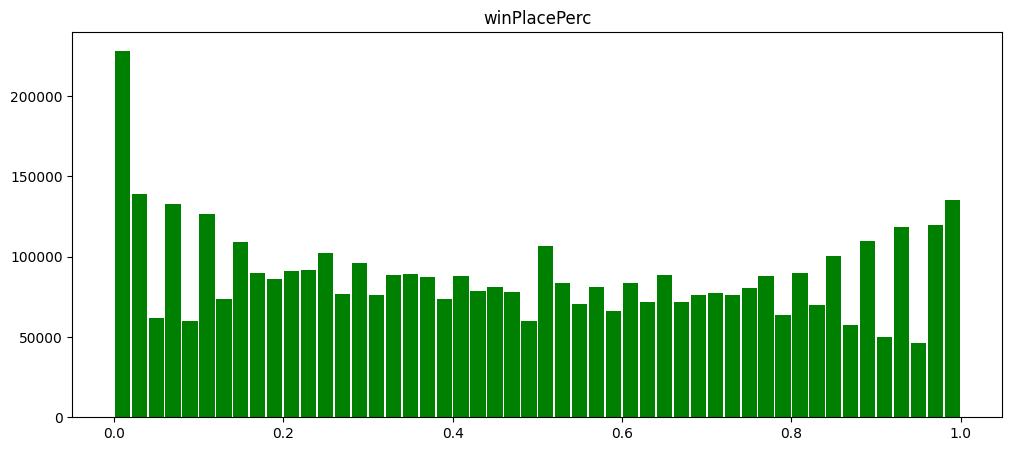

In [4]:
# check how our target data looks like

plt.figure(figsize=(12,5))
plt.hist(train_data['winPlacePerc'], bins=50, color='green', rwidth=0.90)
plt.title("winPlacePerc")
plt.show()

### Data Visualization

std: 0.9824372680299405, mean: 0.0013842533508479696, median: -0.0005841386169606996


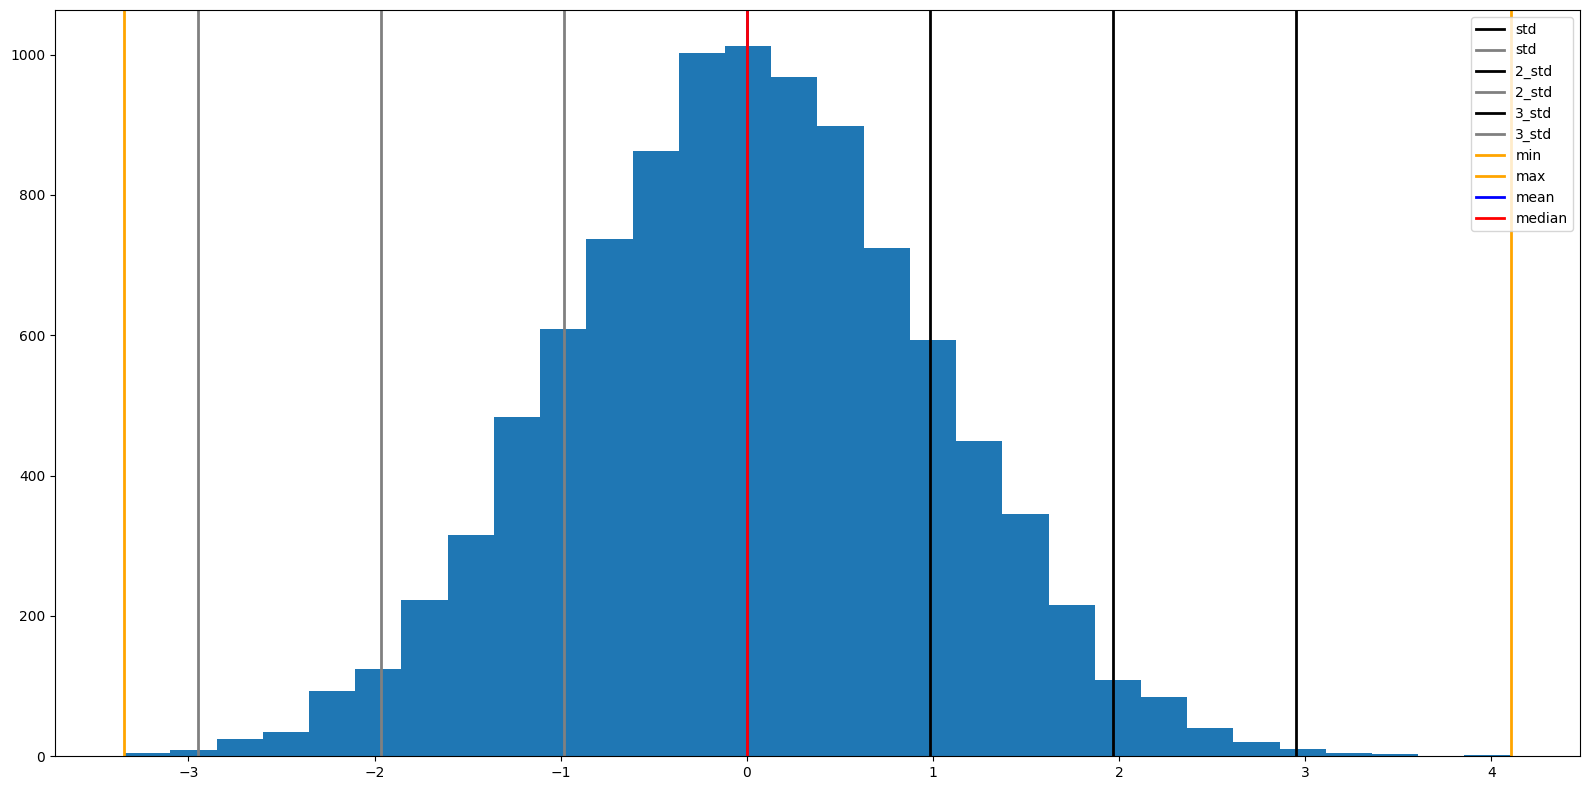

In [27]:
data = np.random.standard_normal(10000)
std = np.std(data)
mean = np.mean(data)
median = np.median(data)
print(f'std: {std}, mean: {mean}, median: {median}')

plt.figure(figsize=(16,8))
plt.hist(data, 30)
plt.axvline(mean+std, color='black', linestyle='-', linewidth=2, label='std')
plt.axvline(mean-std, color='gray', linestyle='-', linewidth=2, label='std')
plt.axvline(mean+2*std, color='black', linestyle='-', linewidth=2, label='2_std')
plt.axvline(mean-2*std, color='gray', linestyle='-', linewidth=2, label='2_std')
plt.axvline(mean+3*std, color='black', linestyle='-', linewidth=2, label='3_std')
plt.axvline(mean-3*std, color='gray', linestyle='-', linewidth=2, label='3_std')
plt.axvline(min(data), color='orange', linestyle='-', linewidth=2, label='min')
plt.axvline(max(data), color='orange', linestyle='-', linewidth=2, label='max')
plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label='mean')
plt.axvline(median, color='red', linestyle='-', linewidth=2, label='median')

plt.legend()
plt.tight_layout()
plt.show()

In [10]:
train_data = train_data.drop(['Id', 'groupId', 'matchId', 'matchType'], axis=1)
#train_data_copy = data.sample(100000)
train_data_copy = train_data.copy()

threshold = train_data_copy.quantile(0.99)
train_data_copy = train_data_copy[train_data_copy <= threshold]

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


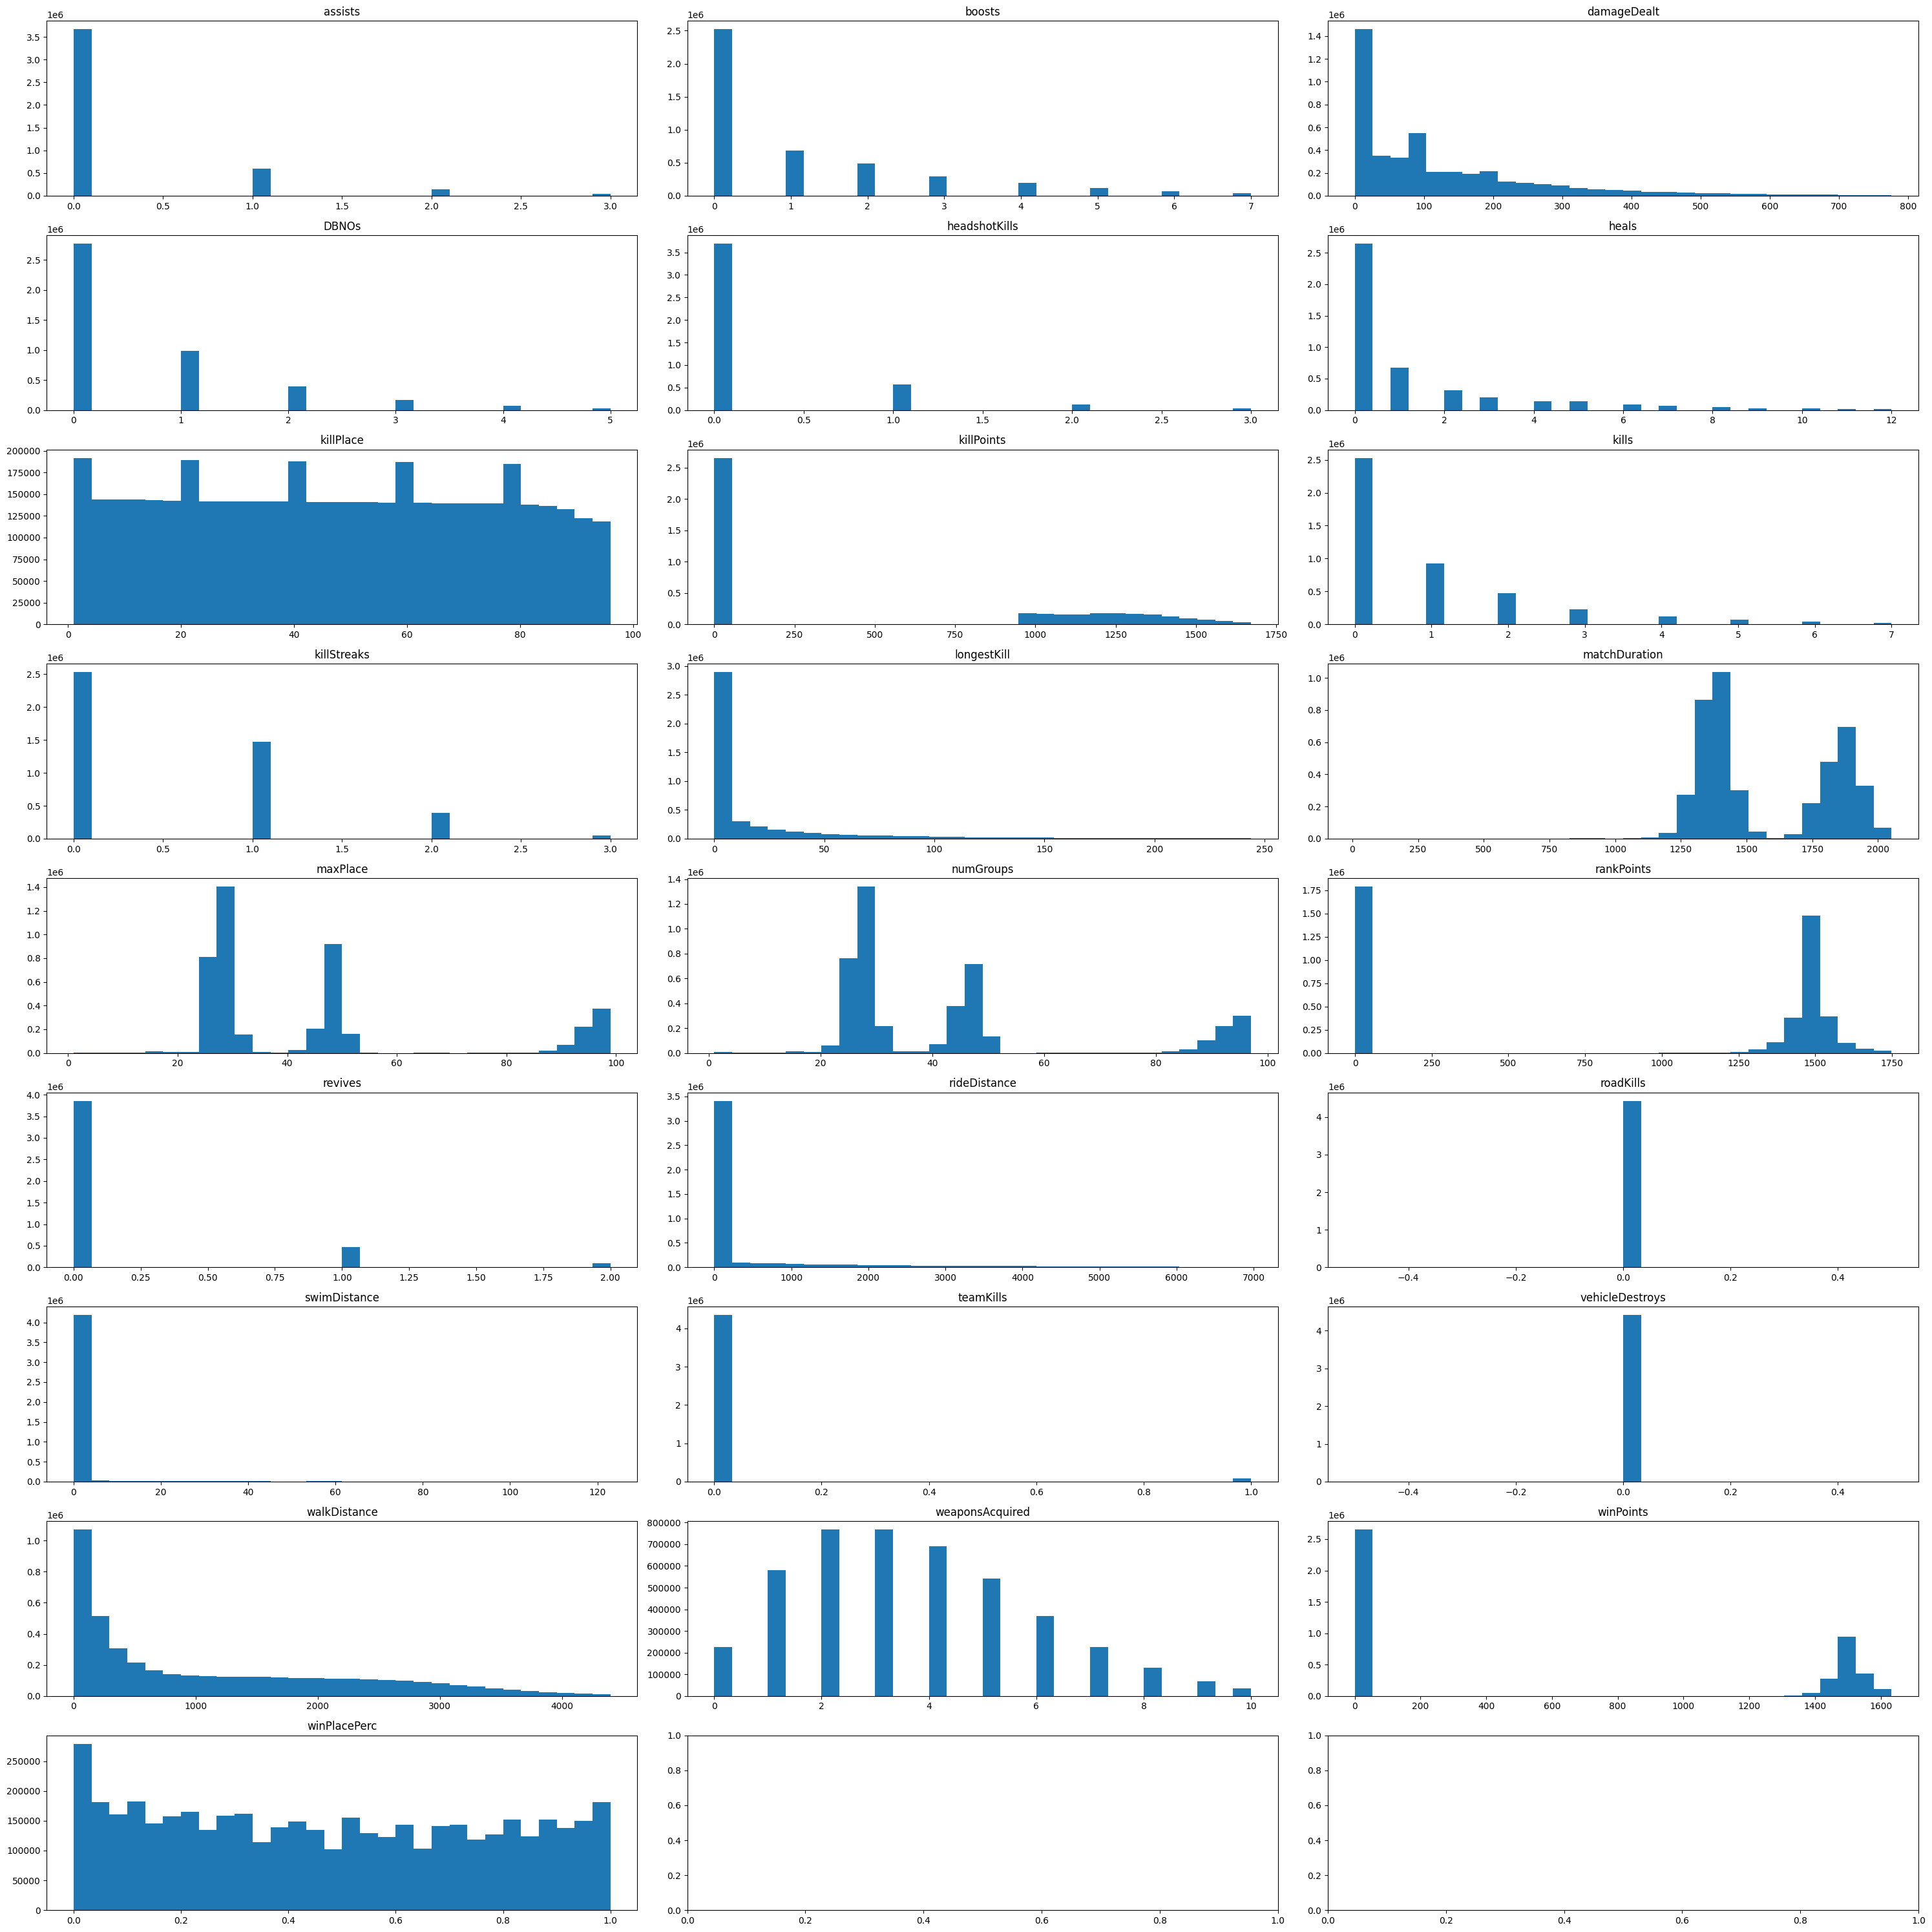

In [ ]:
fig, axs = plt.subplots(nrows=len(train_data_copy.columns)//3 + 1, ncols=3, figsize=(30,30))
axs = axs.flatten()

for idx, col in enumerate(train_data_copy.columns):
    axs[idx].hist(train_data_copy[col], bins=30)
    axs[idx].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
# check our data, except out target

# Set figure size
fig, axes = plt.subplots(nrows=3, ncols=len(X.columns)//3, figsize=(20, 10))
axes = axes.flatten()

# Loop through each column and plot distribution
for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {column}")

# Hide empty subplots if columns are fewer
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Check normal distribution

| **Method**                             | **Description**                                                                                | **Pros** 👍                                                                                                                                                    | **Cons** ⚠️                                                                              | **Typical Use Case**                    | **Practical Example**                                      |
| -------------------------------------- | ---------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | --------------------------------------- | ---------------------------------------------------------- |
| **🌟 Shapiro‑Wilk Test**               | Tests whether a sample comes from a normal distribution using order statistics.                | ✅ Highly powerful, especially for small-to-medium samples; widely available in `scipy`, R| ⚠️ Overly sensitive on large N; limited to continuous data; may flag trivial deviations  | Pre-testing before t-tests, regressions | Checking normality of residuals in regression (N ≈ 30–500) |
| **🔍 Anderson‑Darling Test**           | Gives more weight to tails; compares empirical vs theoretical distribution across whole range. | ✅ Sensitive to tail differences; stronger alternative to K‑S                                                                                                   | ⚠️ Requires distribution‑specific critical values; less intuitive; software-dependent    | Goodness-of-fit in full-range stats     | Testing residual normality including tail behavior         |
| **⚖️ Kolmogorov‑Smirnov (Lilliefors)** | Nonparametric; measures max deviation between empirical & theoretical CDF.                     | ✅ Simple; exact test when distribution known; works with small samples                                                                                         | ⚠️ Less sensitive in tails; wrong if parameters are estimated; often misused             | Quick sanity check; nonparametric tests | Comparing sample distribution to known normal CDF          |

In [ ]:
shapiro_test, p_value = stats.shapiro(train_data['damageDealt'])
kolmo_test, p_value_kolmo = stats.kstest(train_data['damageDealt'], 'norm')

# If our p_value is smaller than 0.05, we could reject null hypothesis and in this case reject that our data follow standard distribution
print(f"Shapiro - {shapiro_test}, {p_value} Kolmogorov - {kolmo_test}, {p_value_kolmo}")

Shapiro - 0.7325563066256384, 1.2327946025335427e-199 Kolmogorov - 0.7185073944791855, 0.0


### Confidence Interval
Range of values that’s likely to include the true population parameter (like the mean) based on your sample.  
It tells you how certain you are about your estimate.

**Purpose**: Estimate how close your sample mean is to the population mean.  

**Interpretation**: “We are 95% confident that the true mean falls between [lower bound, upper bound].”

**When to Use**:

* Evaluating feature distributions
* Estimating performance metrics (e.g., accuracy)
* Understanding prediction uncertainty
* A/B testing and statistical comparisons

In [ ]:
sample_data = train_data['damageDealt']
sample_mean = np.mean(sample_data)
sample_std_err = stats.sem(sample_data)
ci = stats.t.interval(0.95, len(sample_data)-1, loc=sample_mean, scale=sample_std_err)

print(f"Sample Mean: {sample_mean:.2f}")
print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Sample Mean: 130.72
95% Confidence Interval: (130.56, 130.88)


## Bivariate Analysis

### Heatmap

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/tmp/ipykernel_35/2807504447.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


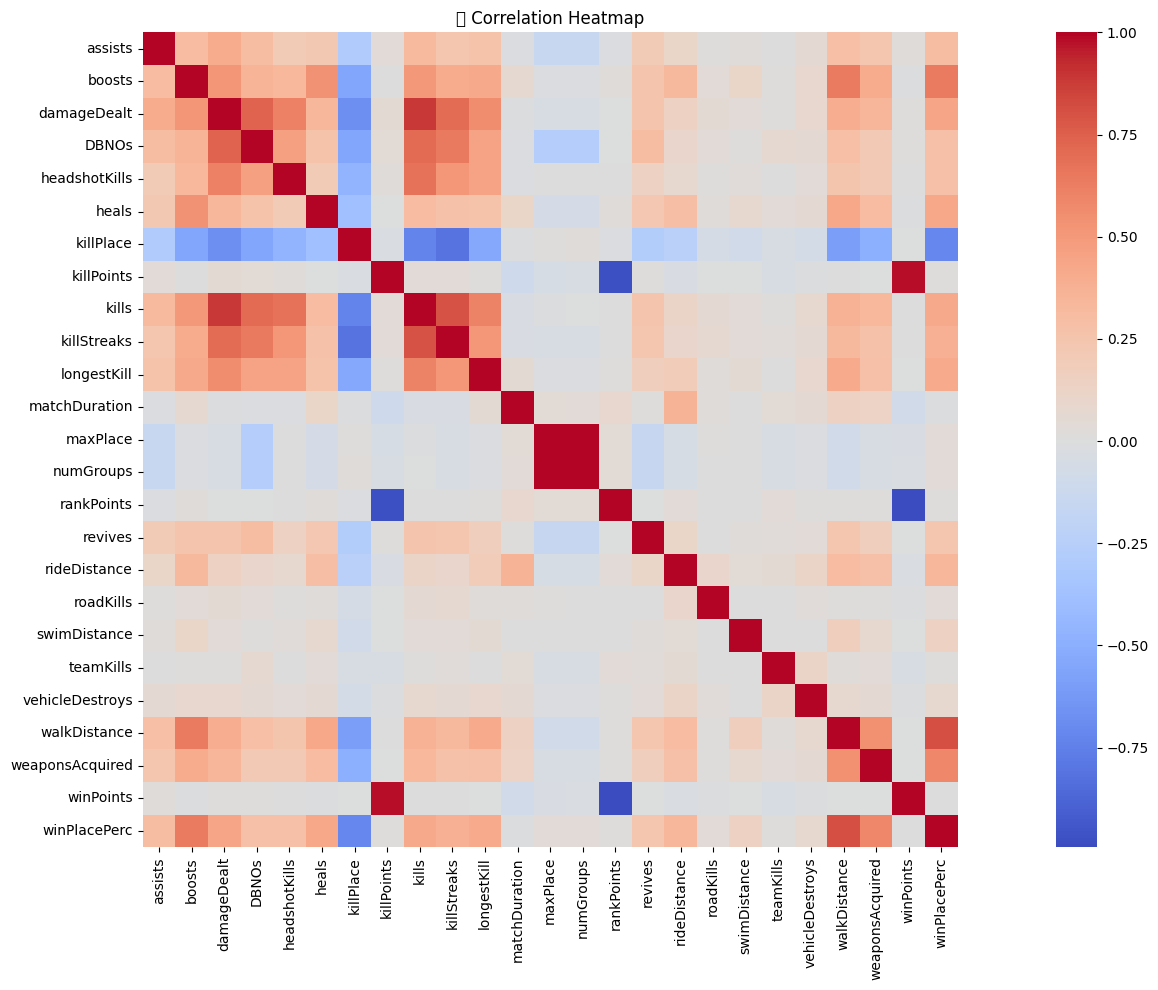

In [12]:
# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title("📊 Correlation Heatmap")
plt.tight_layout()
plt.show()

## Checking outliers/Missing Values

| **Method**                     | **Description**                                                            | **Pros**                                                      | **Cons**                                                               | **Practical Example**                              | **Use Cases**                                                |                     |
| ------------------------------ | -------------------------------------------------------------------------- | ------------------------------------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------- | ------------------------------------------------------------ | ------------------- |
| **Z-Score**                    | Measures how many standard deviations a data point is from the mean.       | Simple to implement; effective for normally distributed data. | Assumes normality; sensitive to extreme outliers.                      | Identifying unusually high test scores in a class. | Univariate outlier detection in normally distributed data.   |                     |
| **Interquartile Range (IQR)**  | Identifies outliers as points beyond 1.5×IQR from Q1 or Q3.                | Non-parametric; robust to non-normal distributions.           | Not suitable for multimodal distributions; limited to univariate data. | Spotting outliers in housing prices.               | Univariate outlier detection in skewed or non-normal data.   |                     |
| **Isolation Forest**           | Randomly partitions data to isolate anomalies quickly.                     | Efficient for large datasets; handles high-dimensional data.  | May struggle with clustered anomalies; randomness can affect results.  | Detecting anomalies in server log data.            | Anomaly detection in large-scale, high-dimensional datasets. |                     |

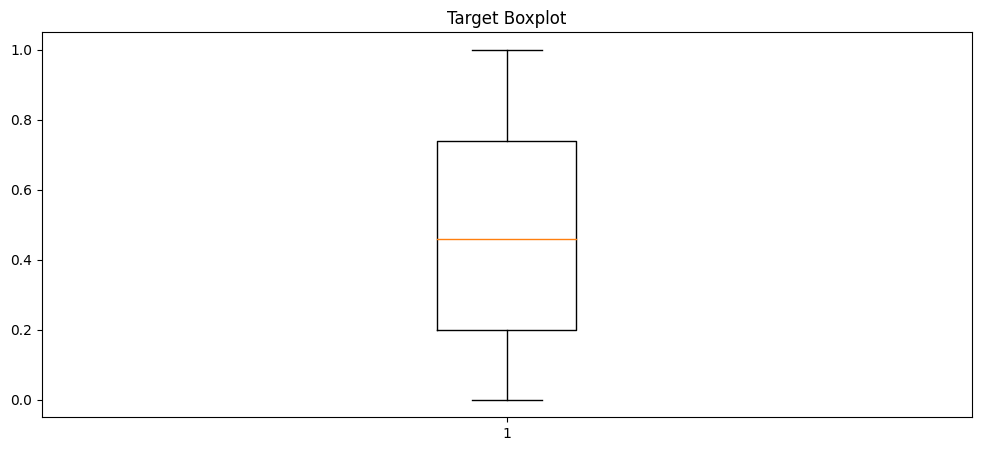

In [36]:
# Check box plot for outliners and distribution

plt.figure(figsize=(12, 5))
plt.boxplot(train_data['winPlacePerc'])
plt.title('Target Boxplot')
plt.show()

In [31]:
def check_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    lower_band = Q1 - 1.5 * IQR
    upper_band = Q3 + 1.5 * IQR

    print(f'IQR - {IQR}\nlower band - {lower_band}, upper band - {upper_band}')

    df = df[(df < lower_band) | (df > upper_band)]
    df_lower = df[df < lower_band]
    df_upper = df[df > upper_band]

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df)
    plt.title(f"Outliers in {df.name}")
    plt.show()

    return df, df_lower, df_upper

In [ ]:
# Isolation Forest
outliers_forest = pd.DataFrame()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers_forest['Outlier_ISO'] = iso_forest.fit_predict(train_data[['damageDealt']])
outliers_forest['Outlier_ISO'] = outliers_forest['Outlier_ISO'].apply(lambda x: 'Outlier' if x == -1 else 'Normal')

IQR - 186.0
lower band - -279.0, upper band - 465.0


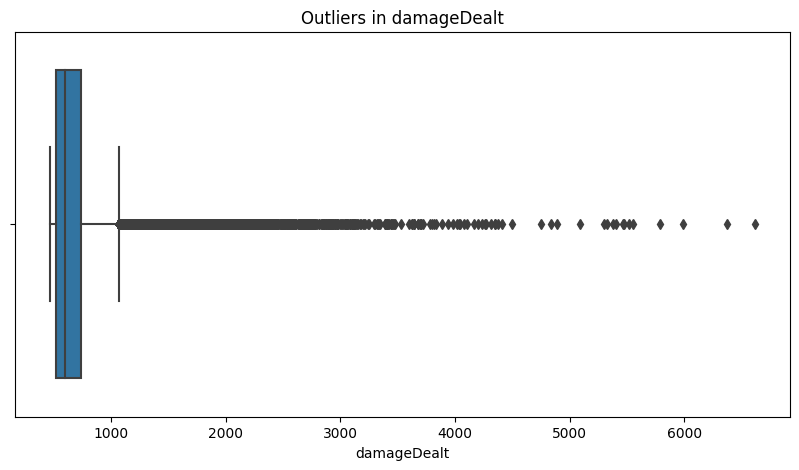

In [33]:
outliers, lower, upper = check_outliers(train_data['damageDealt'])

In [ ]:
# NaN values visualization

nan_counts = train_data.isna().sum()

# Plot bar chart
plt.figure(figsize=(20, 10))
nan_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title("Missing Values Per Column")
plt.xlabel("Columns")
plt.ylabel("Count of NaNs")
plt.xticks(rotation=45)
plt.show()

## Data cleaning

### Missing Values

| **Method**                            | **Description**                                                  | **When to use**                                           | **Pros / Cons**                                          | **Code example (Python/pandas or sklearn)**        |
| ------------------------------------- | ---------------------------------------------------------------- | --------------------------------------------------------- | -------------------------------------------------------- | -------------------------------------------------- |
| **Drop rows/columns**                 | Remove rows/columns with missing values (`listwise deletion`)    | When missing < 5% or column is non‑critical               | ✅ Easy<br>❌ May lose data or bias sample if not MCAR     | `df.dropna(axis=0)`<br>`df.dropna(axis=1)`         |
| **Mean / Median / Mode imputation**   | Fill numeric missings with mean/median; categorical with mode    | When few missing values and MCAR                          | ✅ Simple<br>❌ Reduces variance, distorts correlations    | `df['col'].fillna(df['col'].mean(), inplace=True)` |
| **Forward / Backward fill (LOCF)**    | Use previous/next non‑missing value                              | Time‑series or ordered data                               | ✅ Keeps trend<br>❌ Biased if trend changes               | `df['col'].ffill(inplace=True)`                    |
| **Interpolation**                     | Linear, spline, etc. interpolation                               | Time/continuous data                                      | ✅ Smooth<br>❌ May oversmooth                             | `df['col'].interpolate(method='linear')`           |
| **KNN imputation**                    | Fill values from k‑nearest rows using distance on other features | When relationships between features matter; data MAR/MCAR | ✅ Captures multivariate patterns<br>❌ Slow on large data | `imputer = KNNImputer(n_neighbors=2)` <br> `X_filled = imputer.fit_transform(X)`|

**MCAR** – Missing Completely At Random  
The missingness is totally random and unrelated to any data—observed or missing (*A few survey responses are blank because the paper forms smudged during printing*)  
✅ Safe to drop rows or use simple imputation (mean, median, mode)

**MAR** – Missing At Random  
Missingness depends on observed data, not on the value that’s missing (*People under 25 are less likely to report their income in the survey*)  
✅ Use more advanced imputations (e.g. KNN, multiple imputation, regression imputation).

**MNAR** – Missing Not At Random  
The missingness is related to unobserved or missing data itself (*People with higher incomes don’t report income*)  
🛠 Consider modeling the missingness (e.g. using indicator variables, or building a predictive model for missing values).  

In [ ]:
# drop unimportant values
train_data.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)

# remove nan values
train_data.dropna(inplace=True)

## Data transformation and encoding

| Technique | Example Input | Example Output | When to Use | Code |
|-----------|---------------|----------------|-------------|------|
| **🏷️ Encoding** | `['dog', 'cat', 'bird']` | `[0, 1, 2]` or `[[1,0,0], [0,1,0], [0,0,1]]` | Non-numerical features | `LabelEncoder()` |
| **📏 Scaling** | `[25, 35, 45]` (age) | `[-1.22, 0, 1.22]` | Different feature scales | `StandardScaler()` |
| **🔢 Binning** | `[22, 28, 35, 42, 58]` | `['Young', 'Young', 'Middle', 'Middle', 'Senior']` | Reduce noise, handle outliers | `pd.cut()` |
| **📈 Transformation** | `[1, 10, 100, 1000]` | `[0, 1, 2, 3]` (log) | Skewed data, non-linear | `np.log1p()` |
| **🧮 Creation** | Height: `170cm`, Weight: `70kg` | BMI: `24.2` | Domain knowledge available | Custom functions |
| **✂️ Selection** | 20 features | 5 most important | High dimensionality | `SelectKBest()` |
| **🕒 Time Features** | `'2024-03-15 14:30:00'` | Hour: `14`, DayOfWeek: `4`, Month: `3` | Extract temporal patterns | `dt.hour, dt.dayofweek` |
| **📝 Text Features** | `'I love this product'` | `[0, 2, 0, 1, 1]` (word counts) | Process text data| `CountVectorizer()` |

### Categorical Encoding Table

| Method | Input Example | Output Example | When to Use | Pros | Cons | Code Example |
|--------|---------------|----------------|-------------|------|------|--------------|
| **One-Hot** 🎨 | `['red', 'blue', 'green']` | `red:[1,0,0] blue:[0,1,0] green:[0,0,1]` | Low cardinality (<10-15 categories) | No ordinal assumption, works with all algorithms | High dimensionality, sparse data | `pd.get_dummies(df['color'])` |
| **Label** 🏷️ | `['small', 'medium', 'large']` | `[0, 1, 2]` | Tree-based models, high cardinality | Memory efficient, fast | Implies false ordering | `LabelEncoder().fit_transform(df['size'])` |
| **Target** 🎯 | City:`['NYC', 'LA']` Target:`[0.8, 0.6]` | `NYC:0.8, LA:0.6` | High cardinality (>20 categories) | Captures target relationship | Overfitting risk, needs CV | `df.groupby('city')['target'].mean()` |
| **Binary** 💻 | `['A', 'B', 'C', 'D']` | `A:[0,0] B:[0,1] C:[1,0] D:[1,1]` | Very high cardinality | Compact, logarithmic growth | Less interpretable | Custom binary conversion |
| **Ordinal** 📊 | `['Poor', 'Fair', 'Good', 'Excellent']` | `[1, 2, 3, 4]` | Natural ordering exists | Preserves meaningful order | Requires domain knowledge | `{'Poor':1, 'Fair':2, 'Good':3, 'Excellent':4}` |
| **Frequency** 📊 | `['A', 'B', 'A', 'C']` | `A:2, B:1, C:1` | Frequency matters | Simple, captures popularity | Loses categorical meaning | `df['cat'].value_counts()` |

### Scaling Methods Table

| Method | Input Example | Output Example | Formula | When to Use | Pros | Cons | Code |
|--------|---------------|----------------|---------|-------------|------|------|------|
| **StandardScaler** 📊 | `[10, 20, 30]` | `[-1.22, 0, 1.22]` | `(x-μ)/σ` | Normal distribution, SVM, Neural Networks | Zero mean, unit variance | Sensitive to outliers | `StandardScaler()` |
| **MinMaxScaler** 📏 | `[10, 20, 30]` | `[0, 0.5, 1]` | `(x-min)/(max-min)` | Bounded range needed, preserve zero, Convnet | Bounded [0,1] range | Very sensitive to outliers | `MinMaxScaler()` |
| **RobustScaler** 💪 | `[10, 20, 30, 100]` | `[-0.5, 0, 0.5, 4]` | `(x-median)/IQR` | Outliers present | Robust to outliers | Doesn't guarantee bounds | `RobustScaler()` |
| **Normalizer** 🔄 | `[3, 4]` | `[0.6, 0.8]` | `x/\|\|x\|\|` | Text data, cosin similarity | Unit norm per sample | Changes relative magnitudes | `Normalizer()` |
| **MaxAbsScaler** 🔝 | `[-10, 0, 30]` | `[-0.33, 0, 1]` | `x/max(\|x\|)` | Sparse data, preserve zeros | Preserves sparsity | Sensitive to outliers | `MaxAbsScaler()` |

In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

docs = ["This is a sentence", "Another sentence", "This one is longer and has more words"]

# Vectorize
vectorizer = TfidfVectorizer(norm=None)
X = vectorizer.fit_transform(docs)

# Normalize
normalizer = Normalizer()
X_normalized = normalizer.transform(X)

display(X.toarray())
display(X_normalized.toarray())

(X_normalized @ X.T).toarray() # cosin similarities on normalized data

### Binning Strategies

| Binning Type | Input Example | Output Example | When to Use | Pros | Cons | Code Example |
|--------------|---------------|----------------|-------------|------|------|--------------|
| **Equal Width** 📊 | Ages:`[22, 28, 35, 42, 58, 65]` | `['18-30', '30-42', '42-54', '54-66']` | Uniform distribution | Equal intervals, interpretable | Uneven group sizes | `pd.cut(df['age'], bins=4)` |
| **Equal Frequency** ⚖️ | Income:`[25K, 35K, 45K, 65K, 85K, 120K]` | `['Low', 'Medium', 'High', 'VeryHigh']` (equal counts) | Skewed distributions | Balanced group sizes | Uneven intervals | `pd.qcut(df['income'], q=4)` |
| **Custom/Domain** 🎯 | Credit:`[580, 650, 720, 780]` | `['Poor', 'Fair', 'Good', 'Excellent']` | Domain knowledge available | Meaningful business groups | Requires expertise | `pd.cut(bins=[0,600,700,800,850])` |
| **K-means** 🎲 | Data:`[1,2,3,10,11,12,20,21,22]` | 3 clusters based on similarity | Natural groupings exist | Data-driven boundaries | Complex, needs tuning | `KMeans(n_clusters=3)` |

### Transformation Techniques Table

| Transform | Input Example | Output Example | When Original Data Is | Pros | Cons | Use Cases |
|-----------|---------------|----------------|-----------------------|------|------|-----------|
| **Log** 📈 | `[1, 10, 100, 1000]` | `[0, 2.3, 4.6, 6.9]` | **Positive**, right-skewed, exponential growth | Reduces skewness, stabilizes variance | Can't handle zeros/negatives | Income, population, web traffic |
| **Square Root** √ | `[1, 4, 9, 16, 25]` | `[1, 2, 3, 4, 5]` | **Mild positive**, count data, moderate skewness | Handles zeros, less aggressive than log | Still can't handle negatives | Count data, rates |
| **Box-Cox** 📦 | `[1, 2, 3, 4, 5]` λ=0.5 | `[0, 1.83, 2.45, 3, 3.47]` | **Positive**, need optimal normality | Finds optimal transformation | Needs positive data, complex | Statistical modeling |
| **Yeo-Johnson** 🔄 | `[-2, -1, 0, 1, 2]` | `[-1.41, -0.69, 0, 0.69, 1.41]` | Mixed positive/negative/zero, **Most Flexible** | Handles all values | Less interpretable | General purpose |
| **Reciprocal** 🔃 | `[1, 2, 4, 8]` | `[1, 0.5, 0.25, 0.125]` | **Strong positive**, eavy right tail, inverse relationship | Flips skewness | Can't handle zeros | Time-to-event, rates |

✅ Require or Benefit from **Normality**:
* Linear Regression (normal residuals for inference) 
* Logistic Regression (parametric estimate, convergence)
* LDA / QDA (Gaussian features per class) 
* Gaussian Naive Bayes (feature-wise Gaussian assumption) 
* Gaussian Processes / Probit (Gaussian noise/model)

❌ **No Normality** Required
* Decision Trees / Random Forest (tree splits unaffected by distribution) 
* XGBoost / Gradient Boosted Trees (likewise tree-based) 
* K‑Nearest Neighbors (KNN) (distance-based, needs scaling not normality) 
* Support Vector Machines (SVM) (margin-based, scale but no normality) 
* Neural Networks (universal approximators; scaling helps)
* PCA / clustering (eigen/decomposition & distance-based)

In [ ]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

col_name = 'walkDistance'
train_data_copy_walk = train_data_copy[col_name]
train_data_copy_walk = train_data_copy_walk[train_data_copy_walk != 0]
train_data_copy_walk.dropna(inplace=True)


pt = PowerTransformer(method='yeo-johnson')
johnson_data = pt.fit_transform(train_data_copy_walk[0:1000].to_numpy().reshape(-1, 1))

normal_data = train_data_copy_walk
log_data = np.log(train_data_copy_walk)
sqrt_data = np.sqrt(train_data_copy_walk)
reciprocal = 1/train_data_copy_walk
boxcox_data, _ = boxcox(train_data_copy_walk[0:1000])

data_viz = [normal_data, log_data, sqrt_data, reciprocal, boxcox_data, johnson_data]

display(normal_data.head())
display(log_data.head()) # Log
display(sqrt_data.head()) # Square root
display(reciprocal.head()) # Reciprocal
display(pd.DataFrame(boxcox_data).head()) # Box-Cox
display(pd.DataFrame(transformed).head()) # Yeo-Johnson

0     244.80
1    1434.00
2     161.80
3     202.70
4      49.75
Name: walkDistance, dtype: float64

0    5.500442
1    7.268223
2    5.086361
3    5.311727
4    3.907010
Name: walkDistance, dtype: float64

0    15.646086
1    37.868192
2    12.720063
3    14.237275
4     7.053368
Name: walkDistance, dtype: float64

0    0.004085
1    0.000697
2    0.006180
3    0.004933
4    0.020101
Name: walkDistance, dtype: float64

,0
0,11.453653
1,19.726762
2,9.973634
3,10.760838
4,6.483291


,0
0,-0.629284
1,0.621875
2,-0.853625
3,-0.734297
4,-1.381806


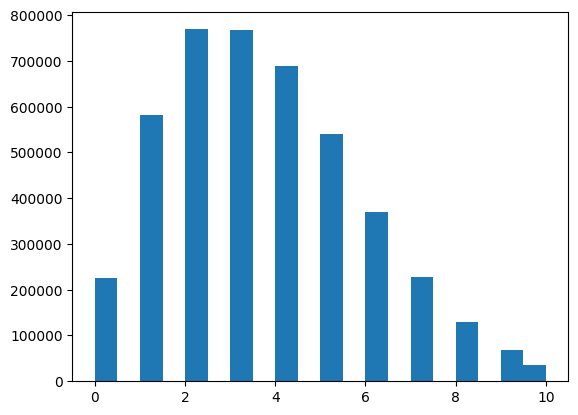

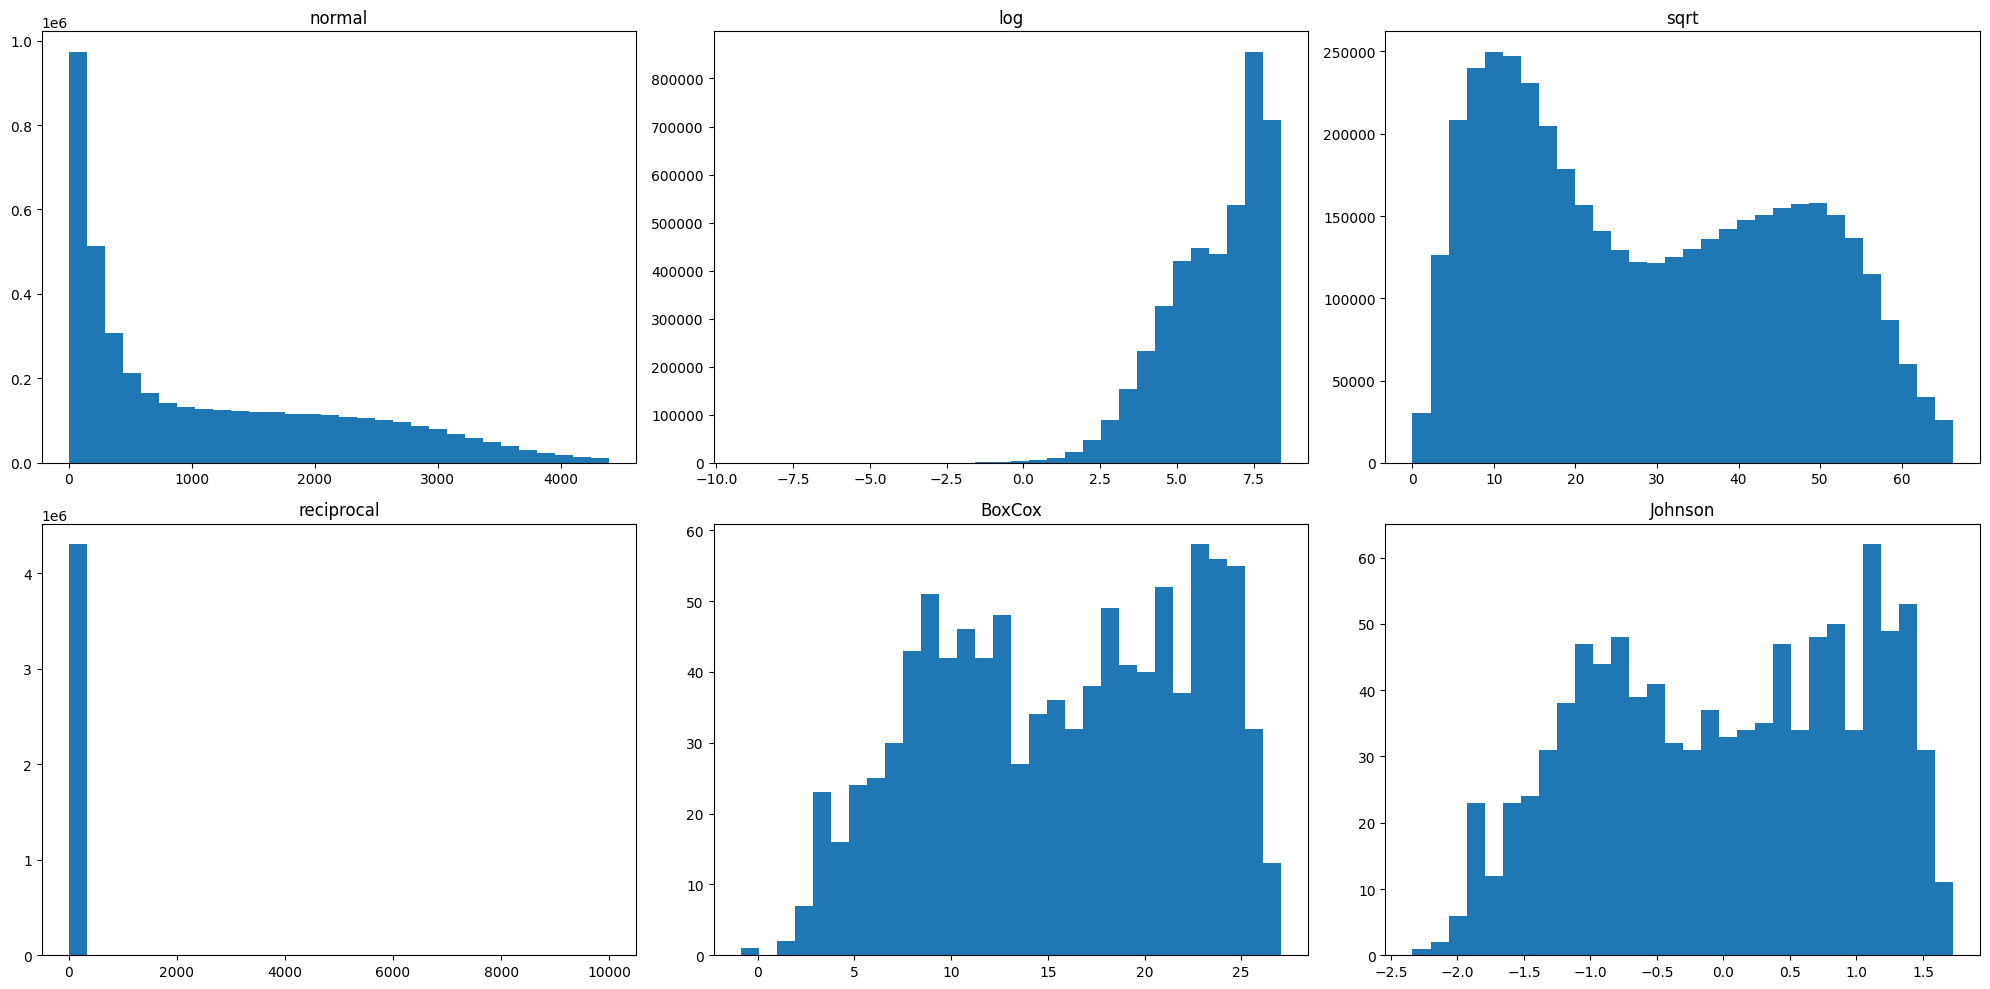

In [ ]:
plt.hist(train_data_copy['weaponsAcquired'], bins=20)
plt.show()

weapon_transform = np.sqrt(train_data_copy['weaponsAcquired'])

axs_names = ['normal', 'log', 'sqrt', 'reciprocal', 'BoxCox', 'Johnson']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axs = axs.flatten()
for idx, data in enumerate(data_viz):
    axs[idx].hist(data, bins=30)
    axs[idx].set_title(axs_names[idx])

plt.tight_layout()
plt.show()

### Time-Based Features Table

| Feature Type | Input Example | Output Examples | When to Use | Pros | Cons | Code Example |
|--------------|---------------|-----------------|-------------|------|------|--------------|
| **Date Parts** 📅 | `'2024-03-15 14:30:00'` | Year:`2024`, Month:`3`, Day:`15`, Hour:`14` | Always with datetime | Simple, interpretable | Linear treatment of cyclical | `df['date'].dt.year` |
| **Cyclical** 🔄 | Hour:`14` | `sin:0.26, cos:-0.97` | Cyclical patterns matter | Captures periodicity properly | Doubles feature count | `np.sin(2*π*hour/24)` |
| **Boolean** ✅ | `'2024-03-15'` (Friday) | `is_weekend:0, is_holiday:0` | Binary time patterns | Simple, clear interpretation | Many sparse features | `df['date'].dt.dayofweek >= 5` |
| **Lag Features** ⏪ | Sales:`[100, 120, 110, 130]` | `lag_1:[NaN, 100, 120, 110]` | Time series forecasting | Captures temporal dependencies | Creates missing values | `df['sales'].shift(1)` |
| **Rolling** 📊 | Sales:`[100, 120, 110, 130, 140]` | `rolling_mean_3:[NaN, NaN, 110, 120, 127]` | Trend analysis needed | Smooths noise, shows trends | Reduces data, needs window choice | `df['sales'].rolling(3).mean()` |

### Text Feature Engineering Table

| Technique | Input Example | Output Example | When to Use | Pros | Cons | Code Example |
|-----------|---------------|----------------|-------------|------|------|--------------|
| **Bag of Words** 👜 | `"I love cats"` | `[1, 1, 1, 0, 0]` (I:1, love:1, cats:1, dogs:0, hate:0) | Simple text classification | Easy to implement | Ignores word order, sparse | `CountVectorizer()` |
| **TF-IDF** 📊 | `"cats are great"` | `[0.57, 0.57, 0.57]` (weighted by rarity) | Text importance matters | Reduces common word impact | Still ignores context | `TfidfVectorizer()` |
| **N-grams** 🔗 | `"I love cats"` | Bigrams: `['I love', 'love cats']` | Word order important | Captures some context | Exponential feature growth | `ngram_range=(1,2)` |
| **Length Features** 📏 | `"Hello world!"` | `char_count:12, word_count:2, avg_word_len:5.5` | Text structure matters | Simple, fast | Limited information | `len(text), len(text.split())` |
| **Sentiment** 😊 | `"I love this product"` | `sentiment_score:0.8, is_positive:1` | Emotion detection needed | Captures meaning | Requires external tools | `TextBlob(text).sentiment` |
| **Word Embeddings** 🎯 | `"This movie was great"`| Contextual vector for each word | When word meaning depends on context  | Context-aware, state-of-the-art | Heavy, slower, complex fine-tuning | `transformers.BertModel` |

### ❌ What to Avoid

| ❌ Mistake | Example | Why It's Wrong | ✅ Correct Approach | Impact |
|------------|---------|----------------|-------------------|---------|
| **Target Leakage** | Using `purchase_date` to predict `will_purchase` | Future info in features | Only use info available before prediction | Inflated performance |
| **Data Leakage** | Scaling before train/test split | Test info leaks into training | Split first, then transform | Overly optimistic results |
| **High Cardinality One-Hot** | One-hot encoding ZIP codes (1000+ values) | Creates 1000+ sparse features | Use target encoding or embedding | Curse of dimensionality |
| **Ignoring Domain** | Generic features for medical data | Misses important relationships | Create medically meaningful features | Poor real-world performance |
| **Over-Engineering** | 500 features for 100 samples | More features than samples | Feature selection or regularization | Severe overfitting |

In [ ]:
# encode string values to ints
train_data['matchType'], mapping = pd.factorize(train_data['matchType'])
match_type = {value: index for value, index in enumerate(mapping)}

## Feature Engineering

### Feature Creation

| Feature Type | Input Features | Formula/Logic | Output Feature | Domain | Pros | Cons |
|--------------|----------------|---------------|----------------|---------|------|------|
| **Ratios** 📊 | Income:`50000`, Experience:`5yr` | `income/experience` | `income_per_year:10000` | HR, Finance | Captures efficiency | Division by zero risk |
| **Differences** ➖ | Current:`25`, Previous:`20` | `current - previous` | `change:5, pct_change:25%` | Time series | Shows trends | Sensitive to outliers |
| **Polynomials** 📈 | Age:`30` | `age², age³` | `age_squared:900` | Non-linear relationships | Captures curves | Overfitting risk |
| **Interactions** 🤝 | Gender:`Male`, Age:`30` | `gender × age` | `male_age:30` (if male=1, else 0) | Marketing, Medicine | Captures combined effects | Exponential feature growth |
| **Aggregations** 📊 | User purchases:`[10, 20, 15]` | `mean, sum, std, count` | `avg_purchase:15, total_spent:45` | Customer analytics | Rich summary stats | Loss of individual info |
| **Distance** 📏 | Lat:`40.7`, Lon:`-74.0` | `haversine distance` | `distance_to_center:5.2km` | Location-based | Captures spatial relationships | Needs reference point |

### Feature Selection

| Method | Example | Selection Criteria | Pros | Cons | When to Use | Code |
|--------|---------|-------------------|------|------|-------------|------|
| **Correlation** 🔗 | Features:`[age, income, education, experience]` | Remove if `corr > 0.9` with others | Simple, fast | Only linear relationships | Multicollinearity issues | `corr_matrix > 0.9` |
| **Variance** 📊 | `[constant_col:all_5, varying_col:1-100]` | Keep if `variance > threshold` | Removes useless features | May remove useful low-variance | Many constant features | `VarianceThreshold(0.01)` |
| **Univariate** 📈 | 10 features, target | Top k by statistical test | Fast, model-agnostic | Ignores feature interactions | High-dimensional data | `SelectKBest(f_classif, k=5)` |
| **RFE** 🔄 | All features | Recursive elimination by model | Considers feature interactions | Computationally expensive | Small-medium datasets | `RFE(estimator, n_features=5)` |
| **L1 Regularization** 🎯 | All features | Non-zero coefficients after penalty | Automatic, embedded | Only works with linear models | Linear model appropriate | `LassoCV()` |
| **Tree Importance** 🌳 | All features | Feature importance scores | Works with non-linear | Model-specific | Tree-based final model | `RandomForest.feature_importances_` |

#### Correlation

| **Method**          | **What It Does**                                                          | **When to Use**                                                                                       | **Pros** 👍                                                                    | **Cons** ⚠️                                                                       | **Example**                                                                    |
| ------------------- | ------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **Pearson**         | Measures *linear* relationship strength between two continuous variables. | Both variables are interval/ratio, approximately **normally distributed**, relationship is linear.    | Simple to compute; interprets magnitude & direction of *linear* correlation.   | **Sensitive to outliers**, assumes normality and homoscedasticity.                | Checking correlation between height and weight of adults                       |
| **Spearman** (ρ)    | Measures *monotonic* relationship via ranked data.                        | Data is ordinal or **not normally distributed**, or relationship is non-linear but monotonic.         | Robust to outliers, non-parametric, handles ordinal and rank data.             | Rank-based: less sensitive to magnitude changes, may lose information.            | Ranking of students' performance across two tests                              |
| **Kendall** (τ)     | Measures ordinal association by comparing concordant/discordant pairs.    | Ordinal data, small samples, many ties, or when requiring a conservative estimate.                    | More **conservative**, interpretable via *pair probability*, robust with ties. | Slightly slower to compute, may be less intuitive.                                | Comparing reviewers’ ranked preferences for a set of items                     |
| **Chi-Square** (χ²) | Tests *independence* between two **categorical** variables.               | When you want to test if there's an association between two nominal or ordinal categorical variables. | Non-parametric, easy to implement, works with frequency data.                  | Requires sufficient expected frequencies; doesn't show *strength* or *direction*. | Testing if gender and voting preference are independent in a sample population |

<br>
<br>

|**r(rho) Value**  | **Strength**      | **Description**                       | **When to Use**                               | **Quick Example**                             |
| ----------------- | ----------------- | ------------------------------------- | --------------------------------------------- | --------------------------------------------- |
| **±0.80 to 1.00** | 🌟 Very Strong    | Almost perfect monotonic relationship | When predictors are highly aligned            | Age and years of work experience (ρ = 0.85)   |
| **±0.60 to 0.79** | ✅ Strong          | Clear and meaningful association      | When variables show a consistent trend        | Temperature vs. ice cream sales (r ≈ 0.70)    |
| **±0.40 to 0.59** | ✔️ Moderate       | Noticeable but moderate dependency    | When moderate predictive power is expected    | Reading hours vs. grades (r ≈ 0.50)           |
| **±0.20 to 0.39** | ⚠️ Weak           | Slight monotonic relationship         | When relationship exists but with variability | Social media time vs. stress level (ρ ≈ 0.30) |
| **0.00 to 0.19**  | 🚫 Very Weak/None | Essentially no monotonic correlation  | When variables are mostly independent         | Shoe size vs. favorite movie rating (r ≈ 0)   |
                                                                                                               |

In [ ]:
rho, p_value = stats.spearmanr(train_data['damageDealt'], train_data['winPlacePerc'])
print(f'Correlation between feature and y: {rho} and p_value - {p_value}')

# Visualizing
# plt.scatter(train_data['damageDealt'], train_data['winPlacePerc'], label='All data', alpha=0.5)
# plt.scatter(train_data['damageDealt'], train_data['winPlacePerc'], color='red', label='Outliers', edgecolors='black')
# plt.xlabel('Feature')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Correlation between outliers and y')
# plt.show()

Correlation between feature and y: 0.44859106232490664 and p_value - 0.0


In [ ]:
# Chi-Square
# Sample categorical data
data = {
    'Pet': ['Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat'],
    'Area': ['Urban', 'Urban', 'Rural', 'Urban', 'Rural', 'Rural', 'Urban', 'Urban', 'Rural', 'Rural']
}

chi_data = pd.DataFrame(data)

# Create a contingency table
contingency_table = pd.crosstab(chi_data['Pet'], chi_data['Area'])
print("Contingency Table:\n", contingency_table)

# Run the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square statistic:", chi2) # how big is the difference between observed and expected values
print("Degrees of freedom:", dof) # How many pieces of informations we need to get, to be able to fill rest of the table (we assume we know sums of every rows and columns)
print("P-value:", p) # are our results statisticaly significant
print("Expected frequencies:\n", expected)

# Interpret result
alpha = 0.05
if p < alpha:
    print("\n✅ There IS a statistically significant relationship between Pet and Area.")
else:
    print("\n❌ There is NO statistically significant relationship between Pet and Area.")


Contingency Table:
 Area  Rural  Urban
Pet               
Cat       3      2
Dog       2      3

Chi-square statistic: 0.0
Degrees of freedom: 1
P-value: 1.0
Expected frequencies:
 [[2.5 2.5]
 [2.5 2.5]]

❌ There is NO statistically significant relationship between Pet and Area.


#### Variance
Tells you how spread out your data is. It measures how far each number in a dataset is from the average (mean).  

**Purpose**: Remove features with low variance, assuming they carry little information.

**Key Idea**: If a feature doesn’t change much across data points (e.g., 95% of values are “1”), it’s unlikely to help a model learn patterns.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

train_data_copy = train_data.copy()
train_data_copy.drop(['Id', 'groupId', 'matchId', 'matchType'], inplace=True, axis=1)
selector = VarianceThreshold(threshold=0.01).set_output(transform='pandas')
X_reduced = selector.fit_transform(train_data_copy)

print(f'removed columns: {train_data_copy.columns[~selector.get_support()]}')

removed columns: Index(['roadKills', 'vehicleDestroys'], dtype='object')


# Modeling

## **XGBoost**

### **XGBoost most important parameters**
| Parameter | Description | Under/Overfitting Impact | Priority | Typical Values | When to Adjust | Key Notes |
|-----------|-------------|-------------------------|----------|----------------|----------------|-----------|
| **n_estimators** | Number of boosting rounds (trees) | More trees → overfitting risk<br>Too few → underfitting | 🔴 HIGH | 100-1000 | Always tune first with early stopping | Use early stopping to find optimal point. Start with 100-500 |
| **max_depth** | Maximum depth each tree can grow | Deeper → overfitting (complex patterns)<br>Shallow → underfitting (too simple) | 🔴 HIGH | 3-8 | If model too simple/complex | Most important complexity control. 6+ for complex data, 3-4 for simple |
| **learning_rate** | Shrinkage applied to each tree | Lower → reduces overfitting<br>Higher → faster learning, overfitting risk | 🔴 HIGH | 0.01-0.3 | Balance with n_estimators | Lower rate + more trees = better generalization. 0.1 is good start |
| **reg_alpha (L1)** | L1 regularization on leaf weights | Higher → less overfitting<br>Promotes feature sparsity | 🟡 MEDIUM | 0-10 | Many irrelevant features | Creates sparse models. Good for feature selection |
| **reg_lambda (L2)** | L2 regularization on leaf weights | Higher → less overfitting<br>Smooths extreme weights | 🟡 MEDIUM | 1-10 | Model overfitting | Default 1 is often good. Increase if still overfitting after other tuning |
| **subsample** | Fraction of training samples per tree | Lower → less overfitting<br>Too low → underfitting | 🟡 MEDIUM | 0.7-1.0 | Large datasets, overfitting | Introduces randomness. 0.8-0.9 often optimal |
| **colsample_bytree** | Fraction of features used per tree | Lower → less overfitting<br>Reduces feature correlation | 🟡 MEDIUM | 0.7-1.0 | High-dimensional data | Especially useful with correlated features. Try 0.8 first |
| **min_child_weight** | Min sum of weights required for leaf | Higher → prevents overfitting<br>Requires statistical significance | 🟢 LOW | 1-10 | Imbalanced/noisy data | Higher values for imbalanced data. Start with 1, increase if overfitting |
| **gamma** | Min loss reduction required for split | Higher → more conservative<br>Prevents unnecessary splits | 🟢 LOW | 0-5 | Trees too deep/complex | Acts as pre-pruning. Increase if max_depth alone isn't enough |
| **scale_pos_weight** | Balance positive/negative class weights | Adjusts class prediction bias | 🔴 HIGH* | neg_samples/pos_samples | Imbalanced classification | *Only for imbalanced data. Essential parameter for class imbalance |

In [ ]:
# Convert data to DMatrix for XGBoost API

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Train baseline XGBoost classifier
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 6,
    "seed": 42
}
bst = xgb.train(params, dtrain, num_boost_round=50, 
                early_stopping_rounds=5, 
                evals=[(dtrain, "train"), (dtest, "test")], verbose_eval=True)

'''
# 4. Evaluate
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.argmax(axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# 5. Hyperparameter tuning with scikit-learn API
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", seed=42)
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 150],
    "subsample": [0.6, 0.8, 1.0]
}
grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# 6. Feature importance
best = grid.best_estimator_
importances = best.feature_importances_
plt.barh(iris.feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()
'''

## Time Series

In [12]:
# Imports

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Generate sample time series data
np.random.seed(42)
dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
trend = np.linspace(100, 200, len(dates))
seasonal = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 365.25)
noise = np.random.normal(0, 5, len(dates))
ts = trend + seasonal + noise

df_series = pd.DataFrame({'date': dates, 'value': ts})
df_series.set_index('date', inplace=True)

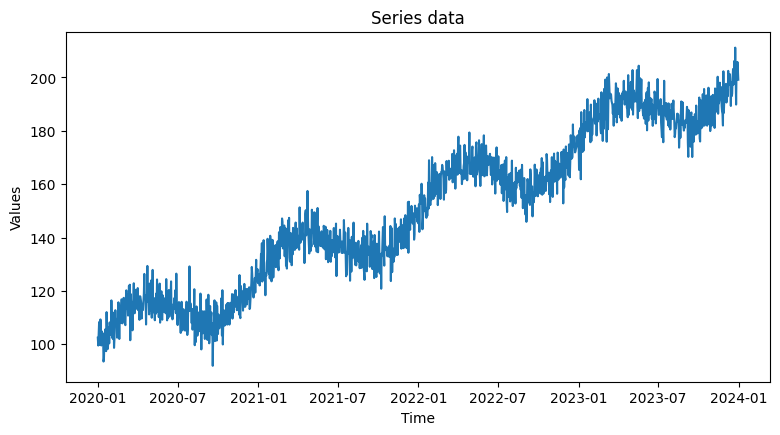

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(df_series.index, df_series.value)
plt.title('Series data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

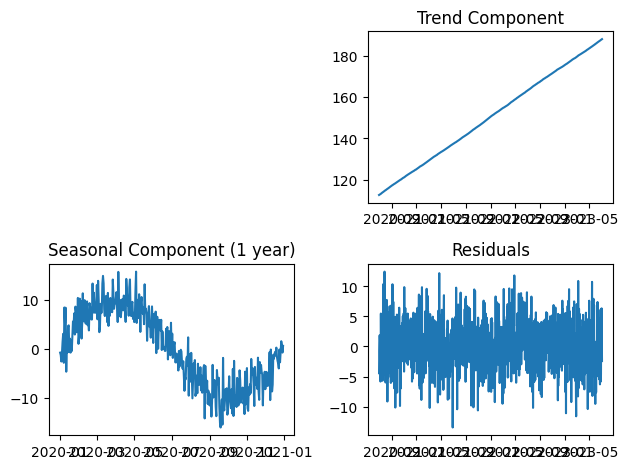

In [13]:
decomposition = seasonal_decompose(df['value'], model='additive', period=365)

plt.subplot(2, 2, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')

plt.subplot(2, 2, 3)
plt.plot(decomposition.seasonal[:365])  # Show one year of seasonality
plt.title('Seasonal Component (1 year)')

plt.subplot(2, 2, 4)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [15]:
# 3. STATIONARITY TESTING
def check_stationarity(ts, title):
    print(f"\n=== {title} ===")
    
    # ADF Test
    adf_result = adfuller(ts.dropna())
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Stationary (ADF): {'Yes' if adf_result[1] < 0.05 else 'No'}")
    
    # KPSS Test
    kpss_result = kpss(ts.dropna())
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print(f"Stationary (KPSS): {'Yes' if kpss_result[1] > 0.05 else 'No'}")

check_stationarity(df['value'], "Original Series")

# Make series stationary through differencing
df_series['diff'] = df_series['value'].diff()
check_stationarity(df_series['diff'], "First Difference")


=== Original Series ===
ADF Statistic: -0.3397
p-value: 0.9197
Stationary (ADF): No
KPSS Statistic: 5.4726
p-value: 0.0100
Stationary (KPSS): No

=== First Difference ===
ADF Statistic: -17.8237
p-value: 0.0000
Stationary (ADF): Yes
KPSS Statistic: 0.1745
p-value: 0.1000
Stationary (KPSS): Yes


In [17]:
# 4. TRAIN-TEST SPLIT
train_size = int(0.8 * len(df))
train = df_series['value'][:train_size]
test = df_series['value'][train_size:]

print(f"\nTrain size: {len(train)}, Test size: {len(test)}")


Train size: 1168, Test size: 293


In [19]:
# 5. FORECASTING MODELS

# Simple Moving Average
def moving_average_forecast(train, test, window=30):
    predictions = []
    for i in range(len(test)):
        if i == 0:
            pred = train.tail(window).mean()
        else:
            # Use last window values from train + previous predictions
            recent_values = list(train.tail(window - i)) + predictions[:i]
            if len(recent_values) >= window:
                recent_values = recent_values[-window:]
            pred = np.mean(recent_values)
        predictions.append(pred)
    print(np.array(predictions))
    return np.array(predictions)

def moving_average_forecast2(train, test, window=30):
    last_window = train[-window:]
    extended_series = pd.concat([pd.Series(last_window), pd.Series([None] * len(test))], ignore_index=True)
    forecast = extended_series.rolling(window=window).mean().iloc[-len(test):]
    print(forecast.values)
    return forecast.values


# Exponential Smoothing (Holt-Winters)
def exponential_smoothing_forecast(train, test):
    model = ExponentialSmoothing(train, 
                                trend='add', 
                                seasonal='add', 
                                seasonal_periods=365)
    fitted_model = model.fit()
    predictions = fitted_model.forecast(len(test))
    return predictions

# ARIMA Model
def arima_forecast(train, test, order=(1,1,1)):
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    predictions = fitted_model.forecast(len(test))
    return predictions

# Generate predictions
ma_pred = moving_average_forecast(train, test)
ma_pred2 = moving_average_forecast2(train, test)
#es_pred = exponential_smoothing_forecast(train, test)
#arima_pred = arima_forecast(train, test)

[187.52066693 187.51878781 187.49301535 187.62637139 187.47889382
 187.5744629  187.62101824 187.71271107 187.76990223 188.00826644
 188.30590476 188.10181384 188.29201696 188.50689626 188.91694799
 189.08268715 189.36247729 189.15199678 189.03453688 189.19091053
 188.85723813 188.71914663 188.78922972 189.21917683 188.86025113
 189.09805631 189.38179155 189.22577891 188.82391564 188.58020861
 188.46083594 188.4921749  188.52462114 188.559008   188.59009589
 188.62713595 188.66222506 188.69693195 188.72973931 188.76173388
 188.78684946 188.80288095 188.82624986 188.84405762 188.85529633
 188.85324128 188.84559308 188.82836361 188.81757584 188.8103438
 188.79765824 188.79567225 188.7982231  188.79852288 188.78450108
 188.78197608 188.77144007 188.75109502 188.73527223 188.73231745
 188.73738774 188.74660614 188.75508718 188.76276938 188.76956142
 188.77554361 188.78049053 188.78443271 188.7873494  188.78926974
 188.7901876  188.79029887 188.78987947 188.78866713 188.78682078
 188.784538

# Deep Learning

## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
# General syntax:

# Creating tensors
x = torch.tensor([1, 2, 3, 4, 5])  # From list
y = torch.zeros(3, 4)              # Zeros tensor
z = torch.randn(2, 3)              # Random normal distribution
w = torch.ones_like(z)             # Same shape as z, filled with ones

# Tensor properties
print(f"Shape: {z.shape}")         # torch.Size([2, 3])
print(f"Data type: {z.dtype}")     # torch.float32
print(f"Device: {z.device}")       # cpu or cuda

# Mathematical operations
a = torch.tensor([1., 2., 3.])
b = torch.tensor([4., 5., 6.])

addition = a + b                    # Element-wise addition
multiplication = a * b              # Element-wise multiplication
dot_product = torch.dot(a, b)       # Dot product
matrix_mult = torch.mm(a.unsqueeze(0), b.unsqueeze(1))  # Matrix multiplication

# Reshaping and indexing
tensor = torch.randn(4, 4)
reshaped = tensor.view(2, 8)        # Reshape (must maintain total elements)
sliced = tensor[:2, 1:3]           # Slicing like NumPy

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to GPU
tensor_gpu = tensor.to(device)
# or
tensor_gpu = tensor.cuda()         # If you're sure GPU is available

# Always ensure tensors are on the same device for operations

In [ ]:
# Pytroch Classes
class Iris_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(perceptron, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        output = self.layers(x)
        return output

In [ ]:
# prepare dataset:
iris_data = pd.read_csv('/kaggle/input/iris/Iris.csv')

iris_x = iris_data.drop(['Species', 'Id'], axis=1)

iris_y = iris_data['Species']
iris_y, target = iris_y.factorize()
target_idx = {values: idx for values, idx in enumerate(target)}

# split data to train and test datasets
x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_y, train_size=0.8)

# convert data into tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


# prepare test and train datasets
train_dataset = Iris_Dataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

test_dataset = Iris_Dataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [ ]:
flower_classifier = perceptron(4, 32, 3)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_classifier.parameters(), lr=0.001)

num_epochs = 100
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

flower_classifier.to(device)

for epoch in range(num_epochs):
    # Training phase
    flower_classifier.train()
    running_loss = 0.0
    
    for data, labels in tqdm(train_dataloader, desc='Training loop'):
        # Move inputs and labels to the device
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = flower_classifier(data)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    flower_classifier.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc='Validation loop'):
            # Move inputs and labels to the device
            data, labels = data.to(device), labels.to(device)
         
            outputs = flower_classifier(data)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(dataloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

## Loss functions

* **Regression**

| **Loss Function**                  | **Explanation**                                                                   | **Use Case**                                                           | **Outlier Sensitivity** |   |
| ---------------------------------- | --------------------------------------------------------------------------------- | ---------------------------------------------------------------------- | ----------------------- | - |
| **Mean Squared Error (MSE)**       | Penalizes larger errors more than smaller ones by squaring the differences.       | Regression tasks where large errors are undesirable.                   | High                    |   |
| **Mean Absolute Error (MAE)**      | Treats all errors equally by taking the absolute difference.                      | Regression tasks requiring robustness to outliers.                     | Low                     |   |
| **Huber Loss**                     | Combines MSE and MAE; behaves like MSE for small errors and MAE for large errors. | Regression tasks with outliers; balances sensitivity.                  | Medium                  |   |
| **Root Mean Squared Error (RMSE)** | Square root of MSE; maintains the same units as the target variable.              | Regression tasks where interpretability in target units is beneficial. | High                    |   |


* **Classification**

| **Loss Function**                   | **Explanation**                                                                              | **Use Case**                                            | **Outlier Sensitivity** |   |
| ----------------------------------- | -------------------------------------------------------------------------------------------- | ------------------------------------------------------- | ----------------------- | - |
| **Binary Cross-Entropy (Log Loss)** | Measures the performance of a classification model outputting probabilities between 0 and 1. | Binary classification problems.                         | High                    |   |
| **Categorical Cross-Entropy**       | Generalization of binary cross-entropy for multi-class classification problems.              | Multi-class classification with one-hot encoded labels. | High                    |   |
| **Hinge Loss**                      | Used for "maximum-margin" classification, primarily with Support Vector Machines (SVMs).     | Binary classification with SVMs.                        | Medium                  |   |


* **Other**

| **Loss Function**                               | **Explanation**                                                                                                                 | **Use Case**                                                            | **Outlier Sensitivity** |   |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------- | ----------------------- | - |
| **Kullback-Leibler Divergence (KL Divergence)** | Measures how one probability distribution diverges from a second, expected probability distribution.                            | Comparing probability distributions; e.g., in variational autoencoders. | High                    |   |
| **Cosine Similarity Loss**                      | Measures the cosine of the angle between two non-zero vectors; assesses similarity.                                             | Text classification and tasks involving high-dimensional vector spaces. | Low                     |   |
| **Triplet Loss**                                | Ensures that the distance between an anchor and a positive example is less than the distance to a negative example by a margin. | Face recognition, metric learning tasks.                                | Medium                  |   |

<br>

When to Use:
<br>

**MSE**: Use when you want to heavily penalize large errors (e.g., forecasting, financial modeling).

**MAE**: Use when all errors should be treated equally, and outliers shouldn't dominate (e.g., evaluating models with noisy data).

**RMSE**: Best when you need a balance between MSE and MAE, keeping errors in the same scale as the original data (e.g., climate modeling, sensor measurements).

## CNN

**How 2D convolution works:**  
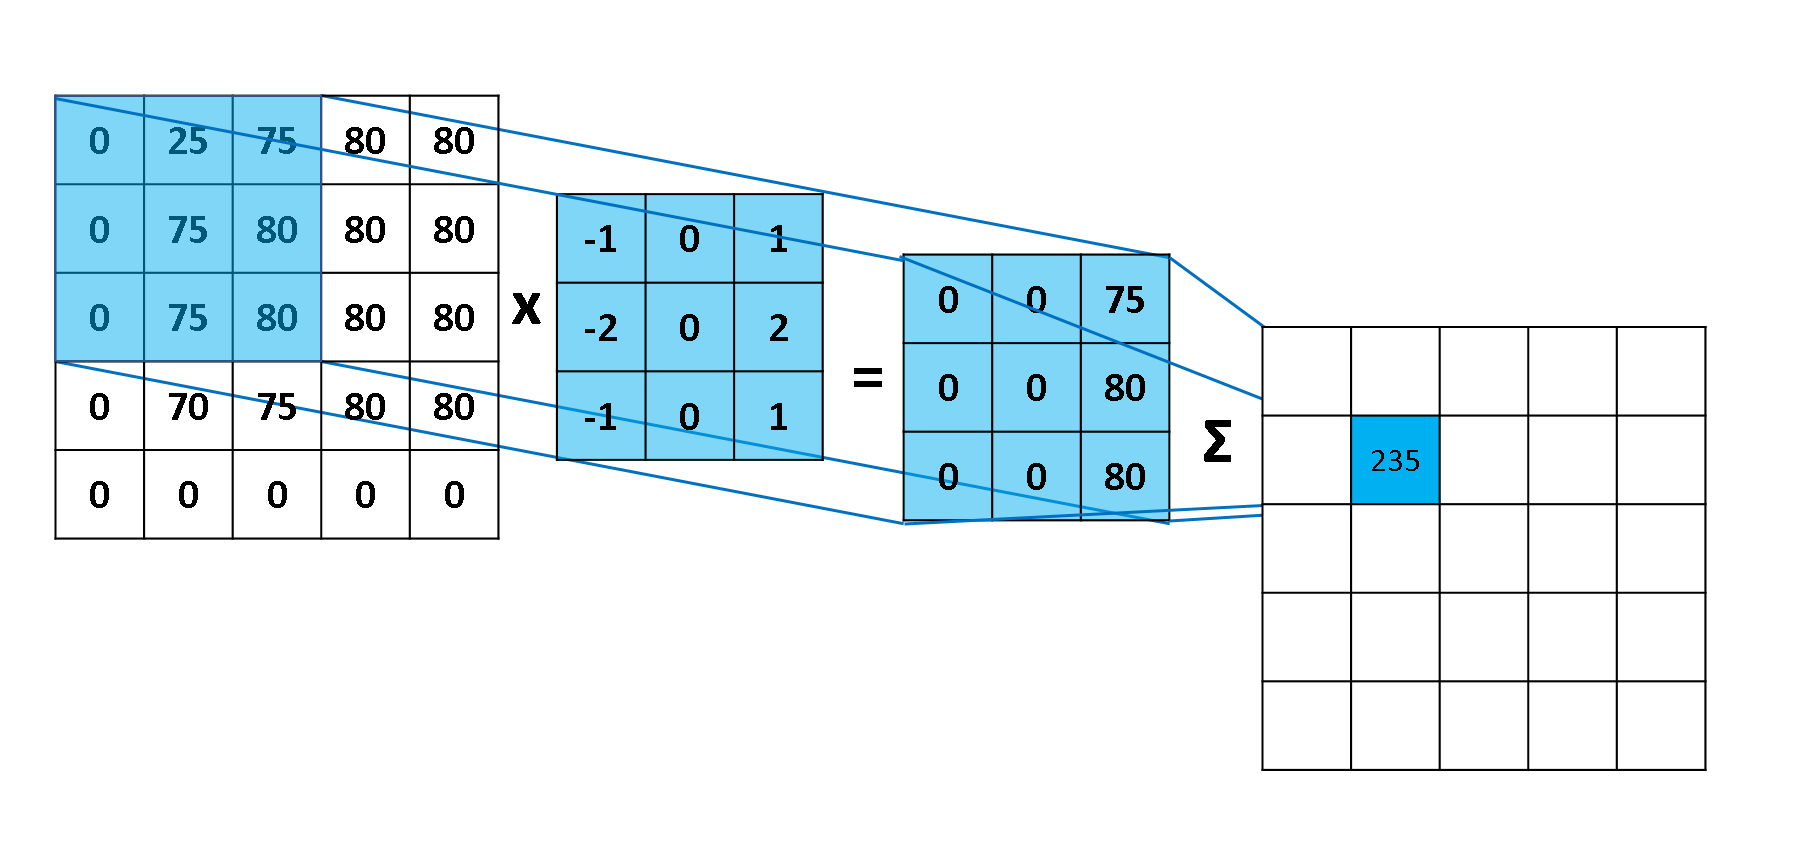

In [3]:
# imports
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

### CV2

In [ ]:
import glob

flowers_path = r'/kaggle/input/flowers-recognition/flowers'
images = glob.glob(f"{flowers_path}/rose/*.jpg")
images[:10]

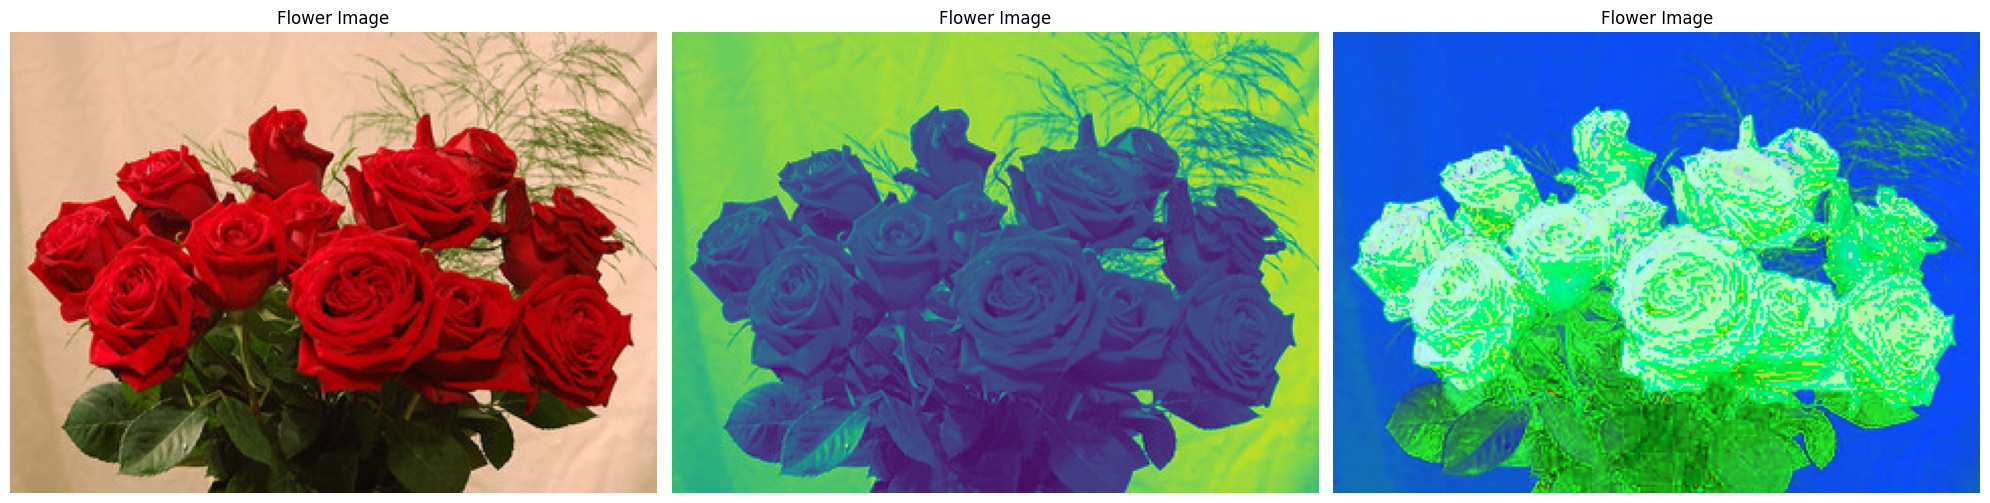

In [ ]:
# load image
flower_path = '/kaggle/input/flowers-recognition/flowers/rose/2265390547_2409007cef_n.jpg'

img = cv2.imread(flower_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

fig, axis = plt.subplots(1, 3, figsize=(20,10))

axis[0].imshow(img_rgb)
axis[0].axis('off')
axis[0].set_title('Flower Image')

axis[1].imshow(gray_image) # Grayscale: Reduces complexity, good for shape detection
axis[1].axis('off')
axis[1].set_title('Flower Image')

axis[2].imshow(hsv_image) # HSV: Better for color-based object detection
axis[2].axis('off')
axis[2].set_title('Flower Image')

plt.tight_layout()
plt.show()

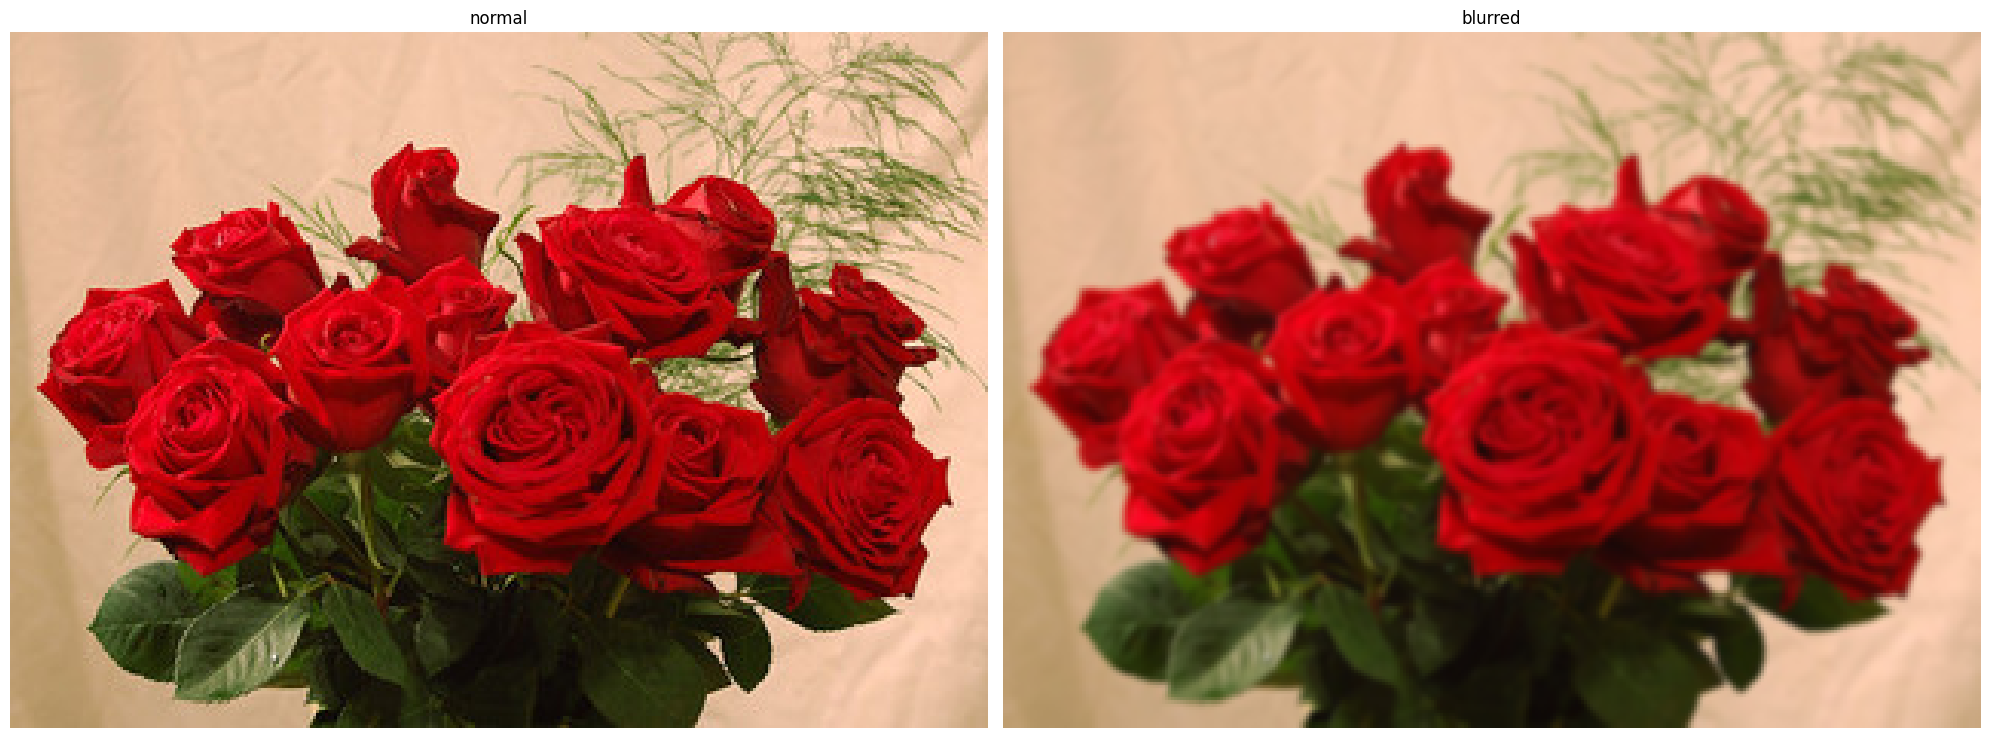

In [18]:
# Real-world images always have noise - this is crucial preprocessing
blurred = cv2.GaussianBlur(img_rgb, (5, 5), 0)

fig, axis = plt.subplots(1, 2, figsize=(20,10))

axis[0].imshow(img_rgb)
axis[0].axis('off')
axis[0].set_title('normal')

axis[1].imshow(blurred)
axis[1].axis('off')
axis[1].set_title('blurred')

plt.tight_layout()
plt.show()

In [ ]:

# 3. EDGE DETECTION
# Edges contain most of the structural information in images
edges = cv2.Canny(gray_image, 50, 150)
print("Canny edge detection applied - identifies object boundaries")

# 4. IMAGE SCALING AND NORMALIZATION
# Deep learning models expect consistent input sizes and value ranges
resized = cv2.resize(sample_image, (224, 224))  # Common size for many models
normalized = resized.astype(np.float32) / 255.0  # Scale to [0,1] range

print(f"Resized to standard input size: {resized.shape}")
print("Normalized pixel values to [0, 1] range")


"""
Feature detection is how traditional computer vision identifies
important points in images. While deep learning has largely replaced this,
understanding features helps you grasp what CNNs are learning automatically.
"""
print("\n=== OPENCV FEATURE DETECTION ===")

# Create a more complex synthetic image with corners and patterns
img = np.zeros((400, 400), dtype=np.uint8)

# Add some geometric patterns that will create distinctive features
cv2.rectangle(img, (50, 50), (200, 150), 255, 2)
cv2.rectangle(img, (100, 200), (300, 350), 255, 2)
cv2.circle(img, (300, 100), 30, 255, 2)

# HARRIS CORNER DETECTION
# Corners are stable features that don't change much with rotation/scaling
corners = cv2.cornerHarris(img, 2, 3, 0.04)
corner_count = np.sum(corners > 0.01 * corners.max())

print(f"Harris corner detection found {corner_count} corner points")
print("Corners are stable features - they look the same from different angles")

# ORB FEATURE DETECTION
# ORB finds keypoints and describes them with binary descriptors
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img, None)

print(f"ORB detected {len(keypoints)} keypoints")
print("Each keypoint has a 256-bit binary descriptor")
print("These descriptors can be matched between different images")}

### Create dataset

In [ ]:
# transform data to fit CNN
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
    ])

flowers_path = r'/kaggle/input/flowers-recognition/flowers'
dataset = ImageFolder(root=flowers_path, transform=transform)

# Calculate lengths
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

### Model creation

In [4]:
class TestCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TestCNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc = nn.Linear(64 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.norm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.norm3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        # Classifier
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Training

In [ ]:
# training
EPOCHS = 8

flower_classifier = TestCNN()

train_loss, val_loss = [], []
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(flower_classifier.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
flower_classifier.to(device)

for epoch in range(EPOCHS):
    flower_classifier.train()
    running_loss = 0

    # training
    for data, labels in tqdm(train_loader, desc='Training loop'):
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        output = flower_classifier(data)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

    train_loss.append(running_loss / len(train_loader.dataset))

    # evaluation
    flower_classifier.eval()
    running_loss = 0

    with torch.no_grad():
        for data, labels in tqdm(val_loader, desc='Validation loop'):
            data, labels = data.to(device), labels.to(device)

            output = flower_classifier(data)
            loss = loss_func(output, labels)
            running_loss += loss.item() * labels.size(0)
        
        val_loss.append(running_loss / len(val_loader.dataset))
        print(f'Epoch: {epoch} \ntraining loss: {train_loss} \nvalidation loss: {val_loss}')

Validation loop: 100%|██████████| 41/41 [00:01<00:00, 22.20it/s]


Epoch: 0 
training loss: [1.2787023446923729] 
validation loss: [1.1413020026370584]


Validation loop: 100%|██████████| 41/41 [00:01<00:00, 22.43it/s]


Epoch: 1 
training loss: [1.2787023446923729, 1.0886069130163563] 
validation loss: [1.1413020026370584, 1.0490469698559557]


Validation loop: 100%|██████████| 41/41 [00:01<00:00, 22.97it/s]


Epoch: 2 
training loss: [1.2787023446923729, 1.0886069130163563, 1.0309428050793468] 
validation loss: [1.1413020026370584, 1.0490469698559557, 0.9739102053310624]


Training loop:  58%|█████▊    | 109/189 [00:05<00:04, 19.34it/s]

### Inference

In [ ]:
test_img = Image.open(r'/kaggle/input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg').convert('RGB')
test_img = transform(test_img).unsqueeze(0)

# after 2 epochs - [0.1209, 0.3016, 0.0307, 0.4907, 0.0561]
# after 5  epochs - [0.2535, 0.3500, 0.0598, 0.2638, 0.0729]

with torch.no_grad():
    output = flower_classifier(test_img)
    probs = torch.softmax(output, dim=1)
    prediction = torch.argmax(probs)
print(dataset.classes)
print(probs)
print(dataset.classes[int(prediction)])

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
tensor([[0.2535, 0.3500, 0.0598, 0.2638, 0.0729]])
dandelion


### Gradient Descent - Visualization

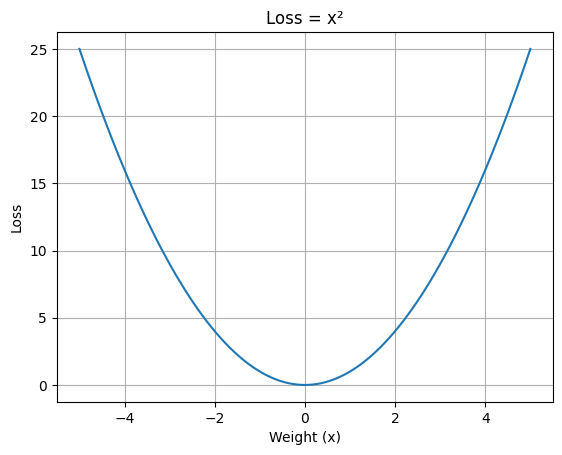

In [6]:
import torch
import matplotlib.pyplot as plt

# Create some x values and a sample loss curve
x = torch.linspace(-5, 5, 100, requires_grad=True)
y = x**2  # a simple loss function: y = x²

plt.plot(x.detach(), y.detach())
plt.title("Loss = x²")
plt.xlabel("Weight (x)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


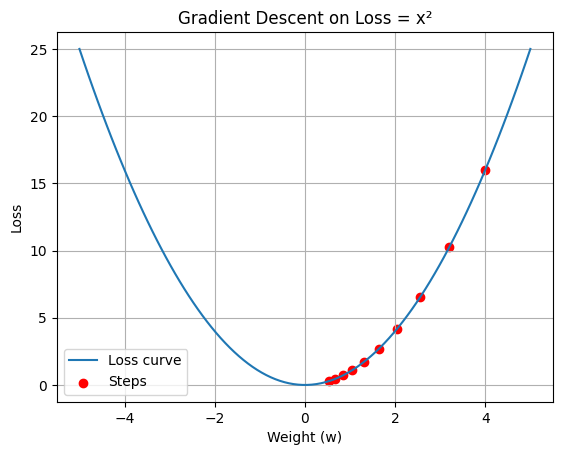

In [7]:
# Start somewhere on the hill (initial weight)
w = torch.tensor([4.0], requires_grad=True)

# Simulate steps down the hill
lr = 0.1  # learning rate
trajectory = []

for step in range(10):
    loss = w**2                  # simple loss function
    loss.backward()              # compute gradient (dL/dw)
    
    with torch.no_grad():
        trajectory.append((w.item(), loss.item()))
        w -= lr * w.grad         # take a step downhill
        w.grad.zero_()           # reset gradients

# Plot the path taken down the hill
x_vals = [pt[0] for pt in trajectory]
y_vals = [pt[1] for pt in trajectory]

plt.plot(x.detach(), y.detach(), label="Loss curve")
plt.scatter(x_vals, y_vals, color='red', label="Steps")
plt.title("Gradient Descent on Loss = x²")
plt.xlabel("Weight (w)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## LLM

TF-IDF stands for Term Frequency–Inverse Document Frequency.  
It’s a classic method used to figure out how important a word is in a document compared to a whole collection of documents.  

*It’s made of two parts:*  
  
**TF (Term Frequency)**: How often a word appears in a document.  
Example: If “bolter” appears 5 times in a 100-word document → TF = 5/100 = 0.05

**IDF (Inverse Document Frequency)**: How rare the word is across all documents.  
If “bolter” appears in only 2 out of 100 documents → IDF = log(100 / 2) ≈ 1.7

### Attention mechanism

| Step | Action                        | What Happens                                                                                | Mini‑Example                               |
| :--: | ----------------------------- | ------------------------------------------------------------------------------------------- | ------------------------------------------ |
|   1  | Tokenize & Embed              | Split sequence into tokens; map each to a d‑dim vector                                      | “I love NLP” → \[v₁, v₂, v₃]               |
|   2  | Project to Q and K            | Compute **Q**, and **K**                                     | **Qᵢ** = V_Q·Vᵢ,  **Kⱼ** = V_K·Vⱼ|
|   3  | Score & Scale                 | For each query Qᵢ, compute raw score sᵢⱼ = Qᵢ·Kⱼᵀ; divide by √(d\_k) to stabilize gradients | s₁₂ = Q₁·K₂ᵀ / √d_k                          |
|   4  | Softmax to Weights            | Normalize scores into attention weights aᵢ = softmax(sᵢ) (we want probabilities)                                  | a₁ = \[0.2, 0.7, 0.1]                      |
|   5  | Weighted Sum → Context Vector | Compute **cᵢ = ∑ⱼ aᵢⱼ·Vⱼ** - This produces an updated token representation by aggregating information from all Vectors                            | c₁ = 0.2·V₁ + 0.7·V₂ + 0.1·V₃              |
|   6  | (Opt.) Multi‑Head & Combine   | Repeat in H “heads” with different W\_Q/W\_K/W\_V; concat & project → richer representation | head₁(c), head₂(c), … → concat → final     |


**Q** - Query - ask “what am I looking for?” at each position (i).  
**K** - Keys - answer “what do I have?” at every **other** position (j).  
**V** - Values - Values with which we **update** our token vector ((softmax of Q·K) · **V**alues_vector)

# Pyspark

| **Category**           | **Description**                                                                     | **When to Use**                                                                                | **Key Concepts / Functions**                                           | **Notes / Tips**                                                                                                                       |
| ---------------------- | ----------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **What is PySpark?**   | Python API for Apache Spark, a distributed computing engine for JVM-based clusters. | Use when handling large-scale data that doesn’t fit in memory or needs distributed processing. | RDD, DataFrame, Spark SQL                                              | Engineered for big data ETL and analytics. |
| **SparkSession**       | Entry point for Spark functionality.                                                | Always required to initiate any PySpark job.                                                   | `SparkSession.builder…`                                                | Like creating a pandas environment but for a cluster.                                                                                  |
| **RDD**                | Low-level distributed data collection with fine control.                            | When performing operations not supported by DataFrames or SQL.                                 | `map()`, `flatMap()`, `filter()`, `reduceByKey()`                      | Generally slower; DataFrames are preferred.                                                                                            |
| **DataFrame**          | Distributed table abstraction with schema support.                                  | Use for ETL and structured analytics.                                                          | `select()`, `filter()`, `groupBy()`, `agg()`, `join()`                 | Lazy evaluation with Catalyst optimizer.                                                                                               |
| **Spark SQL**          | SQL interface over structured data.                                                 | For teams with SQL skills, BI tool integration, or ad-hoc querying.                            | `createOrReplaceTempView()`, `spark.sql("…")`                          | Ideal for BI/analysts.                                                                                                                 |
| **Transformations**    | Define pipelines lazily.                                                            | When constructing DAGs without immediate execution.                                            | `filter()`, `select()`, `withColumn()`                                 | No computation until an action.                                                                                                        |
| **Actions**            | Triggers compute and materializes results.                                          | To finalize pipelines or extract data.                                                         | `show()`, `count()`, `collect()`, `write.save()`                       | Avoid `collect()` on large datasets.                                                                                                   |
| **Joins**              | Combines multiple DataFrames relationally.                                          | Needing to merge big tables.                                                                   | `.join(df2, "key", how="inner")`                                       | Supports all join types.                                                                                                               |
| **UDF / pandas\_udf**  | Apply custom logic to columns/rows in Python.                                       | When built-in functions aren’t enough.                                                         | `F.udf()`, `pandas_udf()`                                              | UDFs can be slow; prefer `pandas_udf` when possible.                                                                                   |
| **Window Functions**   | Perform computations across partitions or sliding windows.                          | For ranking, running totals, or cumulative metrics.                                            | `Window.partitionBy().orderBy()`, `row_number()`, `lag()`              | Great for advanced relational analysis.                                                                                                |
| **MLlib**              | Spark's scalable ML library.                                                        | For distributed model training or ETL-level feature engineering.                               | `VectorAssembler`, `Pipeline`, `LogisticRegression`, `CrossValidator`  | Less comprehensive than scikit‑learn but scales well.                                                                                  |
| **Data Sources**       | Read/write support for diverse formats and systems.                                 | Ingesting/writing data from CSV, Parquet, Hive, JDBC, S3, etc.                                 | `read.csv()`, `read.parquet()`, `write.json()`, JDBC, Hive             | Prefer Parquet/ORC for performance.                                                                                                    |
| **Partitioning**       | Manage physical data distribution across cluster nodes.                             | To optimize I/O and parallelism.                                                               | `repartition()`, `coalesce()`, `partitionBy()`                         | Balance partition count for best performance.                                                                                          |
| **Caching**            | Keep intermediate results in memory or disk.                                        | When reusing data multiple times across operations.                                            | `df.cache()`, `df.persist()`                                           | Monitor memory usage to prevent spills.                                                                                                |
| **Broadcast Join**     | Broadcast small DataFrame to workers to avoid shuffle.                              | If one table is much smaller than the other.                                                   | `broadcast(small_df)`                                                  | Useful for lookup tables.                                                                                                              |
| **Performance Tuning** | Optimize Spark jobs for speed and efficiency.                                       | For heavy or slow jobs.                                                                        | UI tools, `explain()`, partition tuning, caching, broadcast strategies | Use Spark Web UI to identify bottlenecks.                                                                                              |

[1]: https://gagan-mehta.medium.com/pyspark-fundaments-101-pyspark-vs-pandas-fd7d03efd3a5?utm_source=chatgpt.com "Pyspark Fundaments 101 | Pyspark Vs Pandas | by Gagan Mehta | Medium"
[2]: https://medium.com/%40shrestha.baburam/sql-pandas-and-pyspark-are-three-different-tools-used-for-working-with-data-each-with-its-own-f11df0f173db?utm_source=chatgpt.com "SQL, Pandas, and PySpark are three different tools used for working with data, each with its own… | by Shrestha Baburam | Medium"
[3]: https://pandashowto.com/pandas-vs-pyspark-understanding-the-differences-and-when-to-use-each/?utm_source=chatgpt.com "Pandas Vs. PySpark: Understanding The Differences And When To Use Each • Pandas How To"
[4]: https://skphd.medium.com/pyspark-vs-pandas-analysis-interview-questions-and-answers-05d333396820?utm_source=chatgpt.com "PySpark vs Pandas Analysis Interview Questions and Answers | by Sanjay Kumar PhD | Medium"


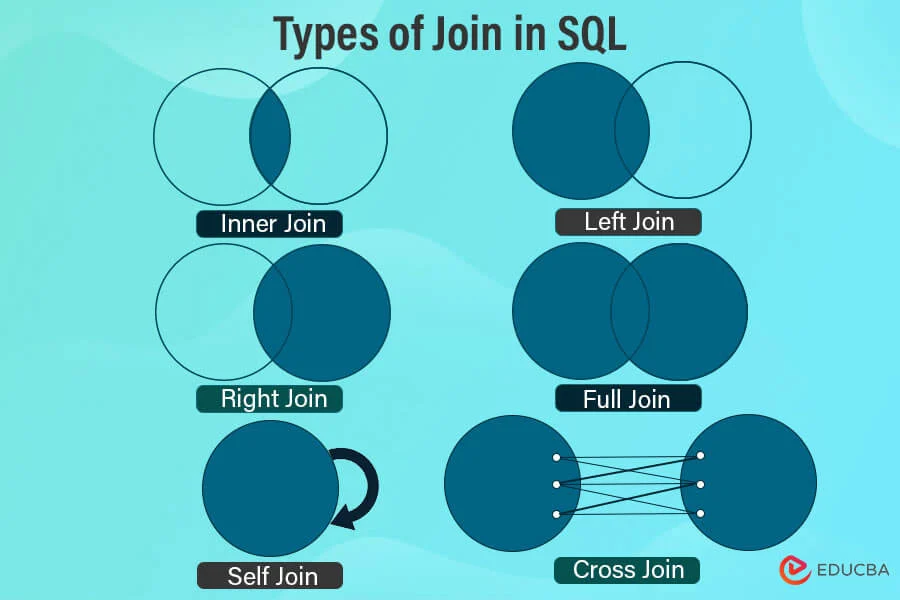

*Cross join - Every combination of both DataFrames.*

In [1]:
# imports

from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("DataManipulation").getOrCreate()

# Read from file
data_path = '/kaggle/input/pubg-finish-placement-prediction/train_V2.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/28 19:23:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df.columns

['Id',
 'groupId',
 'matchId',
 'assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'matchType',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']

In [36]:
df.select(
    percentile('heals', [0.99])
    ).show()

+---------------------------------+
|percentile(heals, array(0.99), 1)|
+---------------------------------+
|                           [12.0]|
+---------------------------------+



In [27]:
df.describe('heals').show()

+-------+------------------+
|summary|             heals|
+-------+------------------+
|  count|           4446966|
|   mean| 1.370147196987789|
| stddev|2.6799822305289855|
|    min|                 0|
|    max|                80|
+-------+------------------+



In [69]:
df.filter('heals > 12 AND damageDealt > 100') \
    .select('DamageDealt', 'heals', 'winPoints') \
    .groupBy('winPoints') \
    .agg(
        sum('DamageDealt').alias('DMG'),
        sum('heals')
    ) \
    .orderBy('winPoints', ascending=False) \
    .show()

+---------+------+----------+
|winPoints|   DMG|sum(heals)|
+---------+------+----------+
|     2002| 632.9|        20|
|     1990| 179.3|        15|
|     1958| 306.1|        22|
|     1953| 391.7|        16|
|     1929| 393.7|        13|
|     1928| 419.9|        15|
|     1920| 146.8|        32|
|     1905| 534.6|        15|
|     1902| 823.4|        26|
|     1901| 584.8|        15|
|     1899| 125.4|        14|
|     1892|1187.0|        13|
|     1890| 385.2|        14|
|     1887| 131.1|        13|
|     1886| 545.4|        24|
|     1885| 763.3|        15|
|     1879| 592.9|        19|
|     1873| 205.2|        15|
|     1872| 576.9|        14|
|     1871| 799.2|        23|
+---------+------+----------+
only showing top 20 rows



## window

In [ ]:
# Define window specification
window_spec = Window.partitionBy("winPoints").orderBy(col('damageDealt'))

# Add rankings
df_window = (
    df.withColumn("rank", rank().over(window_spec))               # skips next rank (number) after tie [1,2,2,4]
      .withColumn("row_number", row_number().over(window_spec))   # don't skips next rank (number) after tie [1,2,2,3]
      .withColumn("dense_rank", dense_rank().over(window_spec))   # every rank is unique [1,2,3,4]
)

# Running totals
window_sum = Window.partitionBy("winPoints").orderBy("damageDealt").rowsBetween(Window.unboundedPreceding, Window.currentRow) # gives cumulative sum of every previous record
df_rows = df.withColumn("running_total", sum("damageDealt").over(window_sum))

df_window.sort(desc('winPoints')).show()
df_rows.sort(desc('winPoints')).show()

In [ ]:
# without "rowsBetween" we got only sum of current row, so basicy values from our column
df_window.withColumn('sum_all', sum('damageDealt').over(window_spec)) \
    .sort(desc('WinPoints')).show()

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+----+----------+----------+------------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchType|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|rank|row_number|dense_rank|           sum_all|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+------

## Joins

In [ ]:
df_1, df_2 = df.randomSplit([0.4, 0.6])

inner_join = df_1.join(df_2, df_1.groupId == df_2.groupId, 'inner')
inner_join.show()

## Data transformation

In [34]:
df_sample = df.sample(fraction=0.1)
df_sample.withColumn("Killers_ranking",
                      when(col('kills') <= 0, 'n00b') \
                      .when((col('kills') > 0) & (col('kills') < 10), 'gamer') \
                      .when(col('kills') > 10, 'Pro')
).show(5)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+---------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchType|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|Killers_ranking|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+-

# General Machine learning concepts

## Regularization

**What?:**   

**Regularization** is a set of techniques that impose additional constraints or penalties on model parameters during training. Its goal is to prevent overfitting by discouraging overly complex models and encouraging simpler ones.

**Why?:**
- Control Overfitting: Models with too many parameters can fit noise in the training data, leading to poor generalization on new data.

- Bias–Variance Trade‑Off: Regularization adds a bit of bias (via penalty) to reduce variance, often lowering total error on unseen data.

- Feature Selection & Interpretability: Some methods (e.g. Lasso) set redundant feature coefficients to zero, effectively selecting a subset of predictors.

**How?:**  

1. Choose a Penalty Term Incorporate into loss: Regularized Loss = Data Loss + **𝜆** × Penalty ​
2. Standardize Features Ensure all predictors are on comparable scales (zero mean, unit variance). 
3. Select Regularization Strength **(λ)** Tune via cross‑validation (e.g., grid search over **λ** values). 
4. Train & Validate Fit model on training set; evaluate on validation set to pick the best **λ**. 
5. Retrain on Full Data Once **λ** is chosen, retrain using combined training + validation data before final testing.

**Examples:**  

| Method             | How It Works                                                                    | Use Cases                                         | Pros & Cons                                                                                                   |
| ------------------ | ------------------------------------------------------------------------------- | ------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **Ridge**          | Adds a penalty proportional to the square of coefficient magnitudes             | When predictors are multicollinear                | • Pros: Stabilizes estimates; keeps all features<br>• Cons: No feature selection                              |
| **Lasso**          | Adds a penalty proportional to the absolute value of coefficients               | Feature selection in high‐dimensional data        | • Pros: Drives some coefficients exactly to zero<br>• Cons: Can be unstable if features are highly correlated |
| **Elastic Net**    | Blends Ridge (L2) and Lasso (L1) penalties via a mixing parameter α             | Correlated features, very high dimensions         | • Pros: Balances shrinkage and sparsity<br>• Cons: Requires tuning two hyperparameters (λ and α)              |
| **Group Lasso**    | Applies Lasso‐style penalty to predefined groups of features simultaneously     | When features naturally form groups               | • Pros: Entire groups can be excluded<br>• Cons: Needs correct grouping a priori                              |
| **Dropout**        | Randomly “drops” (zeros out) a fraction of units during neural network training | Deep learning, especially large nets              | • Pros: Simple to implement; reduces co‑adaptation<br>• Cons: Slows training convergence                      |
| **Early Stopping** | Halts training once validation error stops improving                            | Any iterative training (e.g. boosting, deep nets) | • Pros: No extra penalty term; easy to monitor<br>• Cons: Requires a held‑out validation set                  |
| **Weight Decay**   | Equivalent to applying an L2 penalty on network weights during backpropagation  | Neural networks in most DL frameworks             | • Pros: Built into many libraries; smooths weight updates<br>• Cons: Similar behavior to Ridge, no sparsity   |


## Central Limit Theorem
**Key Idea**:  
If you take many random samples from any population and compute their means, the distribution of those means will be approximately normal and similiar to the mean of the population (as long as the sample size is large enough (usually ≥ 30).)

## Bagging/Boosting

**Bagging**: Asking 10 friends the same question and taking the average of their answers. Each friend sees a slightly different version of the question.

**Boosting**: Single friend learning from their mistakes over time—each time they get feedback, they improve their answer.

| Feature                     | 🧺 Bagging                          | 🚀 Boosting                          |
|----------------------------|------------------------------------|-------------------------------------|
| **Goal**                   | Reduce **variance**                | Reduce **bias**                     |
| **Model Training**         | Models trained **independently**   | Models trained **sequentially**     |
| **Data Sampling**          | Random subsets with **replacement** | Focus on **misclassified** samples  |
| **Model Weighting**        | All models have **equal weight**   | Models are **weighted by accuracy** |
| **Error Handling**         | Averages predictions to smooth noise | Learns from **previous errors**     |
| **Overfitting Risk**       | Lower (good for noisy data)        | Higher (needs careful tuning)       |
| **Popular Algorithms**     | Random Forest                      | AdaBoost, Gradient Boosting, XGBoost|
| **Best For**               | High-variance models               | High-bias models                    |
